In [1]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from ridgeplot import ridgeplot
from scipy import stats
from scipy.stats import ttest_ind
# plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from pandas.plotting import parallel_coordinates


import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv(r'..\Preprocessed_datasets\final_preprocessed_compas.csv', index_col=0)
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)
# Number of errors
# display(len(raw_data.loc[raw_data['errors']==1]))
# # display(len(raw_data.loc[raw_data['errors']==0]))
# display(raw_data)

### Utils

In [4]:
def pca_plot(data, title, alpha):
    """ Function to perform dimensionality reduction on the features, so that we can create 2-dimensional scatterplots.
    Takes as input the entire dataset, selects the features on which we want to cluster, and stores them in a temporary pd Dataframe. 
    This df is used to create a seaborn scatterplot. """
    
    pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
    other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]
    
    df = pd.DataFrame(pca_features)
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)
    temp_dataset = pca.join(other_features, how='left')
    temp_dataset.rename( columns={0 :'Principal Component 1'}, inplace=True )
    temp_dataset.rename( columns={1 :'Principal Component 2'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="clusters", size='errors', sizes=(150, 30), palette="tab10")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    # plt.savefig('germancredit_kmeans.png', dpi=300) # for saving a plot
    plt.show()

def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """ Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
        new_data['scaled_errors'] = new_data['errors'] * 0.8 

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    ''' This function returns the value of a random cluster
    clusters Df.Column the column clusters '''
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    print('This is the random cluster we have picked:', result)
    return result

def plot_clusters(data):
    ''' This function returns a scatterplot of the clusters ''' 
    scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    ''' This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" '''
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. Cluster: ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    ''' This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors '''
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    ''' This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    ''' This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            print('current bias: ', current_bias)
            print('max abs bias: ', max_abs_bias)
            max_abs_bias = current_bias
    print('discriminating bias is:', max_abs_bias)
    return max_abs_bias

def get_max_bias_cluster(fulldata, function=bias_acc):
    ''' This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: # Outliers in DBScan, which are excluded
            continue
        current_bias = (function(fulldata, cluster_number, "clusters")) # abs function to find the highest bias
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    print('cluster with the highest discriminating bias:', best_cluster)
    return best_cluster

def calculate_variance(data):
    ''' This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg '''
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    ''' Returns the size of the smallest new cluster '''
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

# 1. Hierarchical Bias-Aware KMeans Clustering 

In [14]:
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
}

In [20]:
full_data = initialize_dataset(raw_data)
full_data.head()

# pca_plot(full_data, 'Compas', 0.6)

Number_of_Priors  score_factor  Age_Above_FourtyFive  \
4590         -0.672808      1.125535             -0.497974   
2482          0.560285      1.125535             -0.497974   
4092         -0.672808     -0.888466              2.008136   
165          -0.672808     -0.888466             -0.497974   
1109          1.587862      1.125535             -0.497974   

      Age_Below_TwentyFive  African_American     Asian  Hispanic  \
4590              1.899201          0.969158 -0.065866 -0.303284   
2482              1.899201         -1.031824 -0.065866 -0.303284   
4092             -0.526537         -1.031824 -0.065866 -0.303284   
165               1.899201          0.969158 -0.065866 -0.303284   
1109             -0.526537         -1.031824 -0.065866  3.297240   

      Native_American     Other    Female  Misdemeanor  scaled_errors  \
4590         -0.04028 -0.231235 -0.476763     1.331336            0.8   
2482         -0.04028 -0.231235 -0.476763    -0.751125            0.8   
4092         -0.04028  4.324596  2.097479    -0.751125            0.8   
165          -0.04028 -0.231235 -0.476763    -0.751125            0.8   
1109         -0.04028 -0.231235 -0.476763     1.331336            0.8   

      predicted_class  true_class  errors  clusters  new_clusters  
4590                0           1       1         0            -1  
2482                1           0       1         0            -1  
4092                0           1       1         0            -1  
165                 0           1       1         0            -1  
1109                1           0       1         0            -1

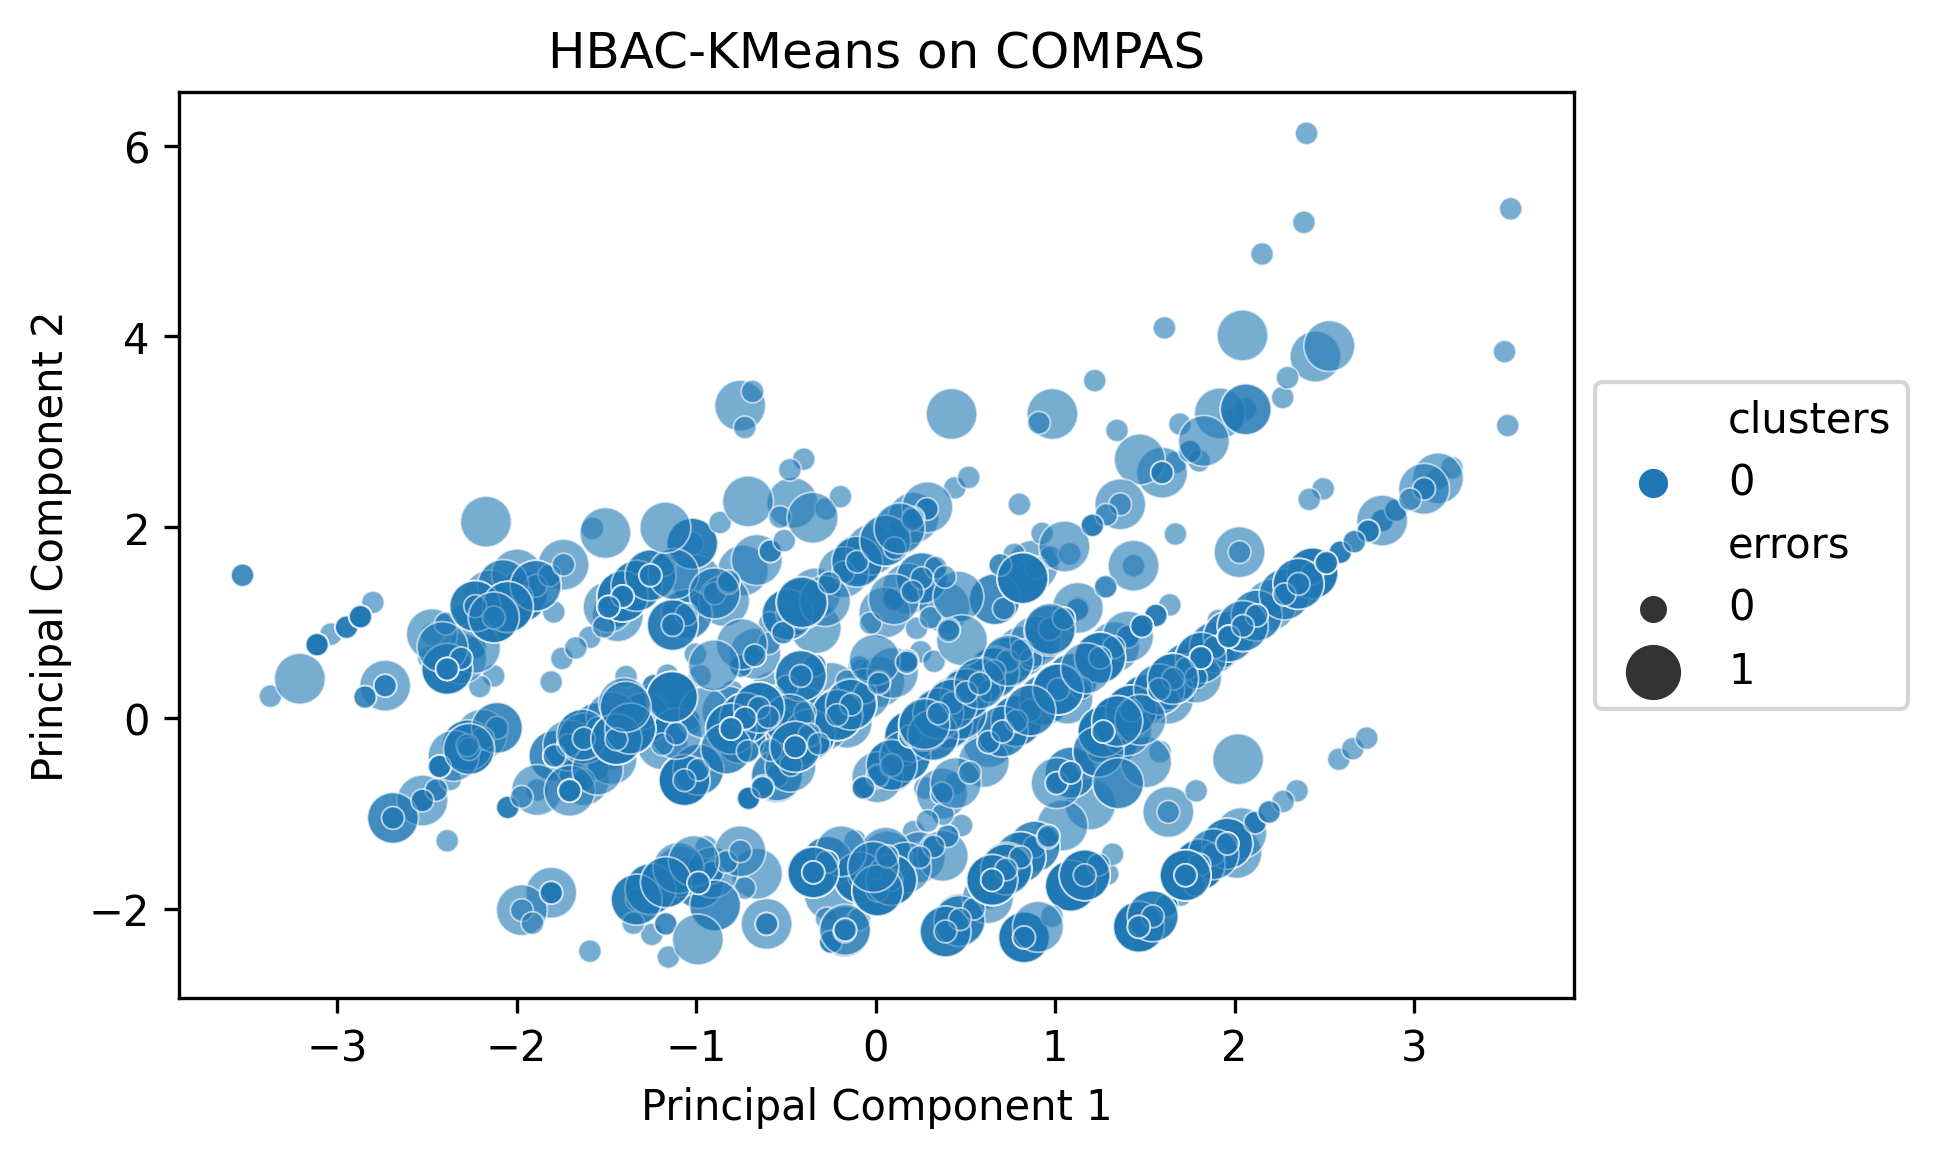

average_accuracy is:  0.6727861771058316
discriminating bias is: -999999


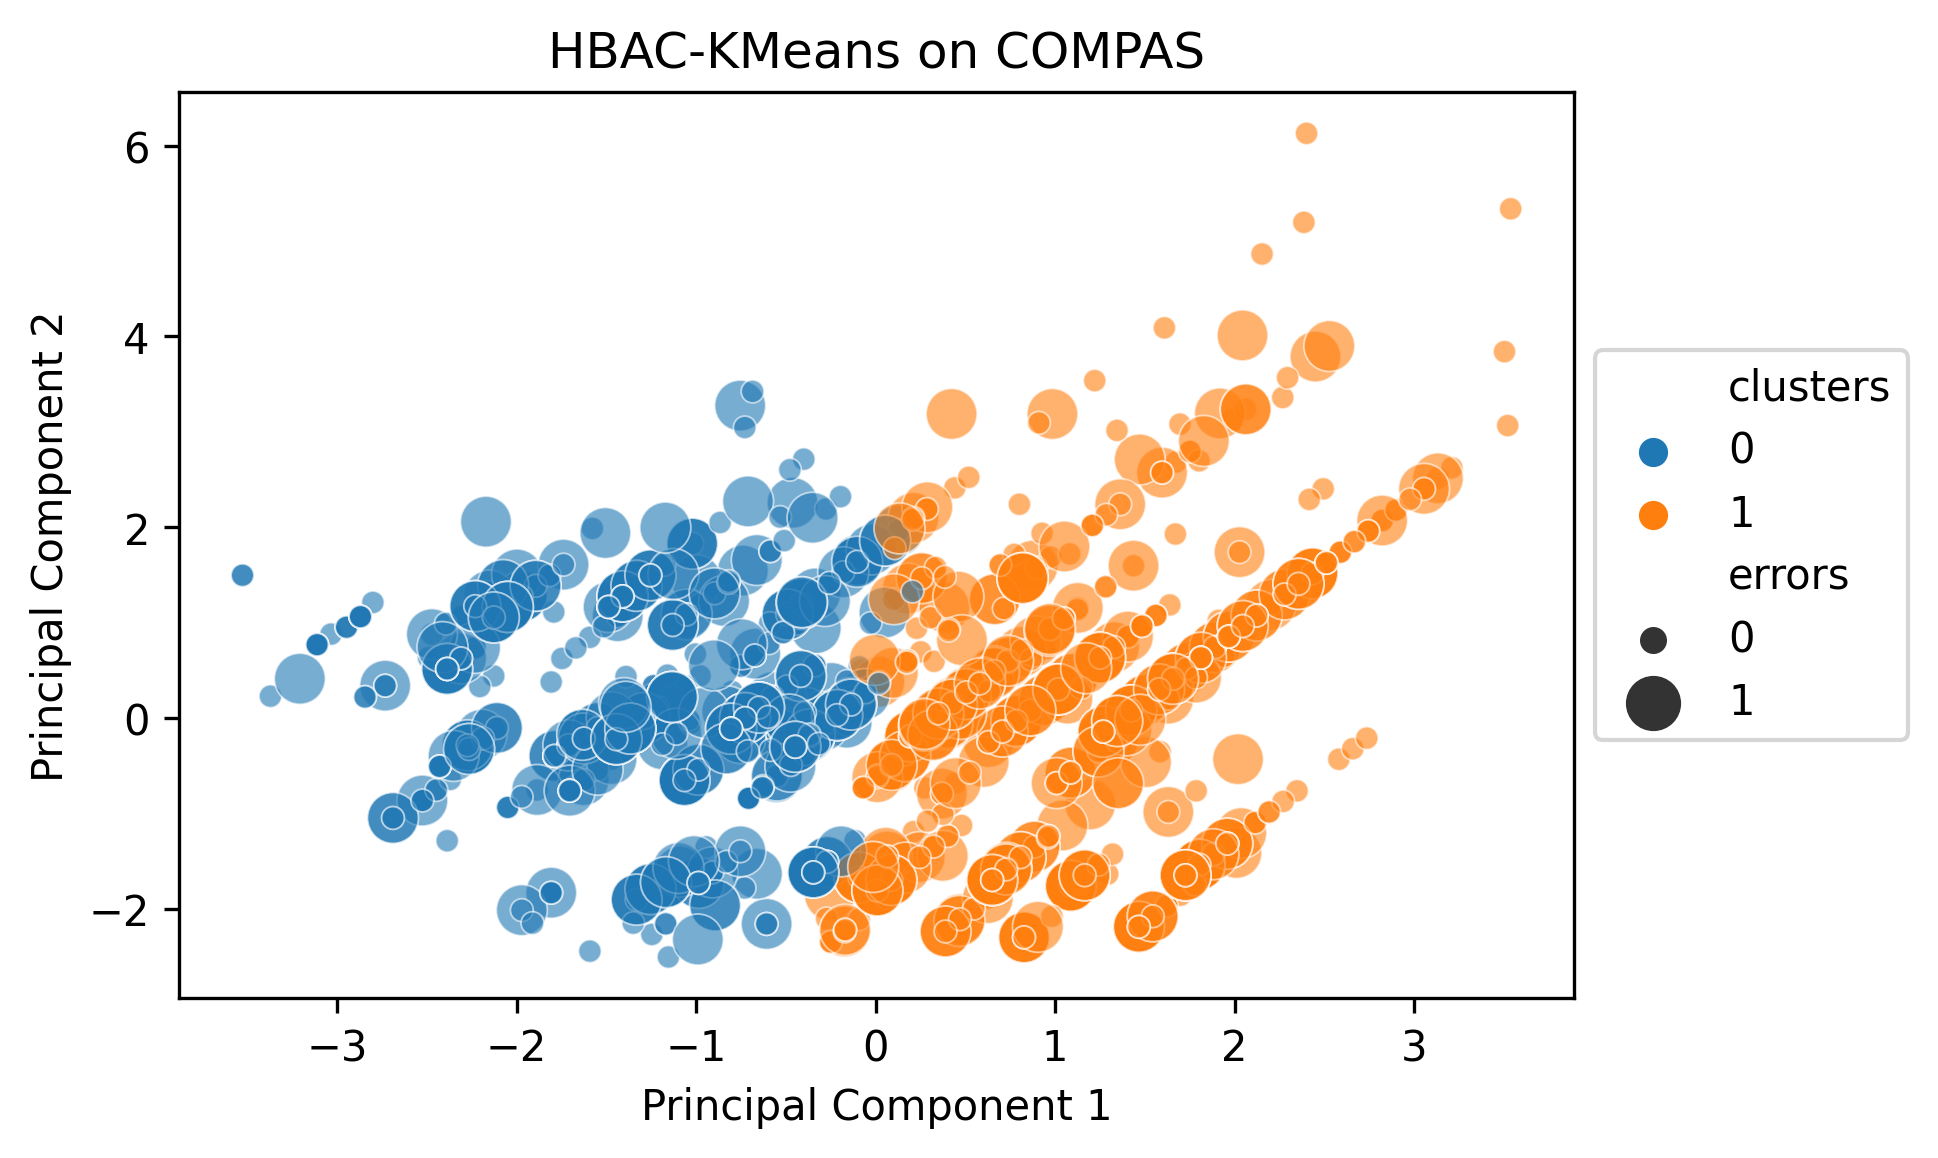

--> Cluster with the highest variance: 1
discriminating bias is: -999999


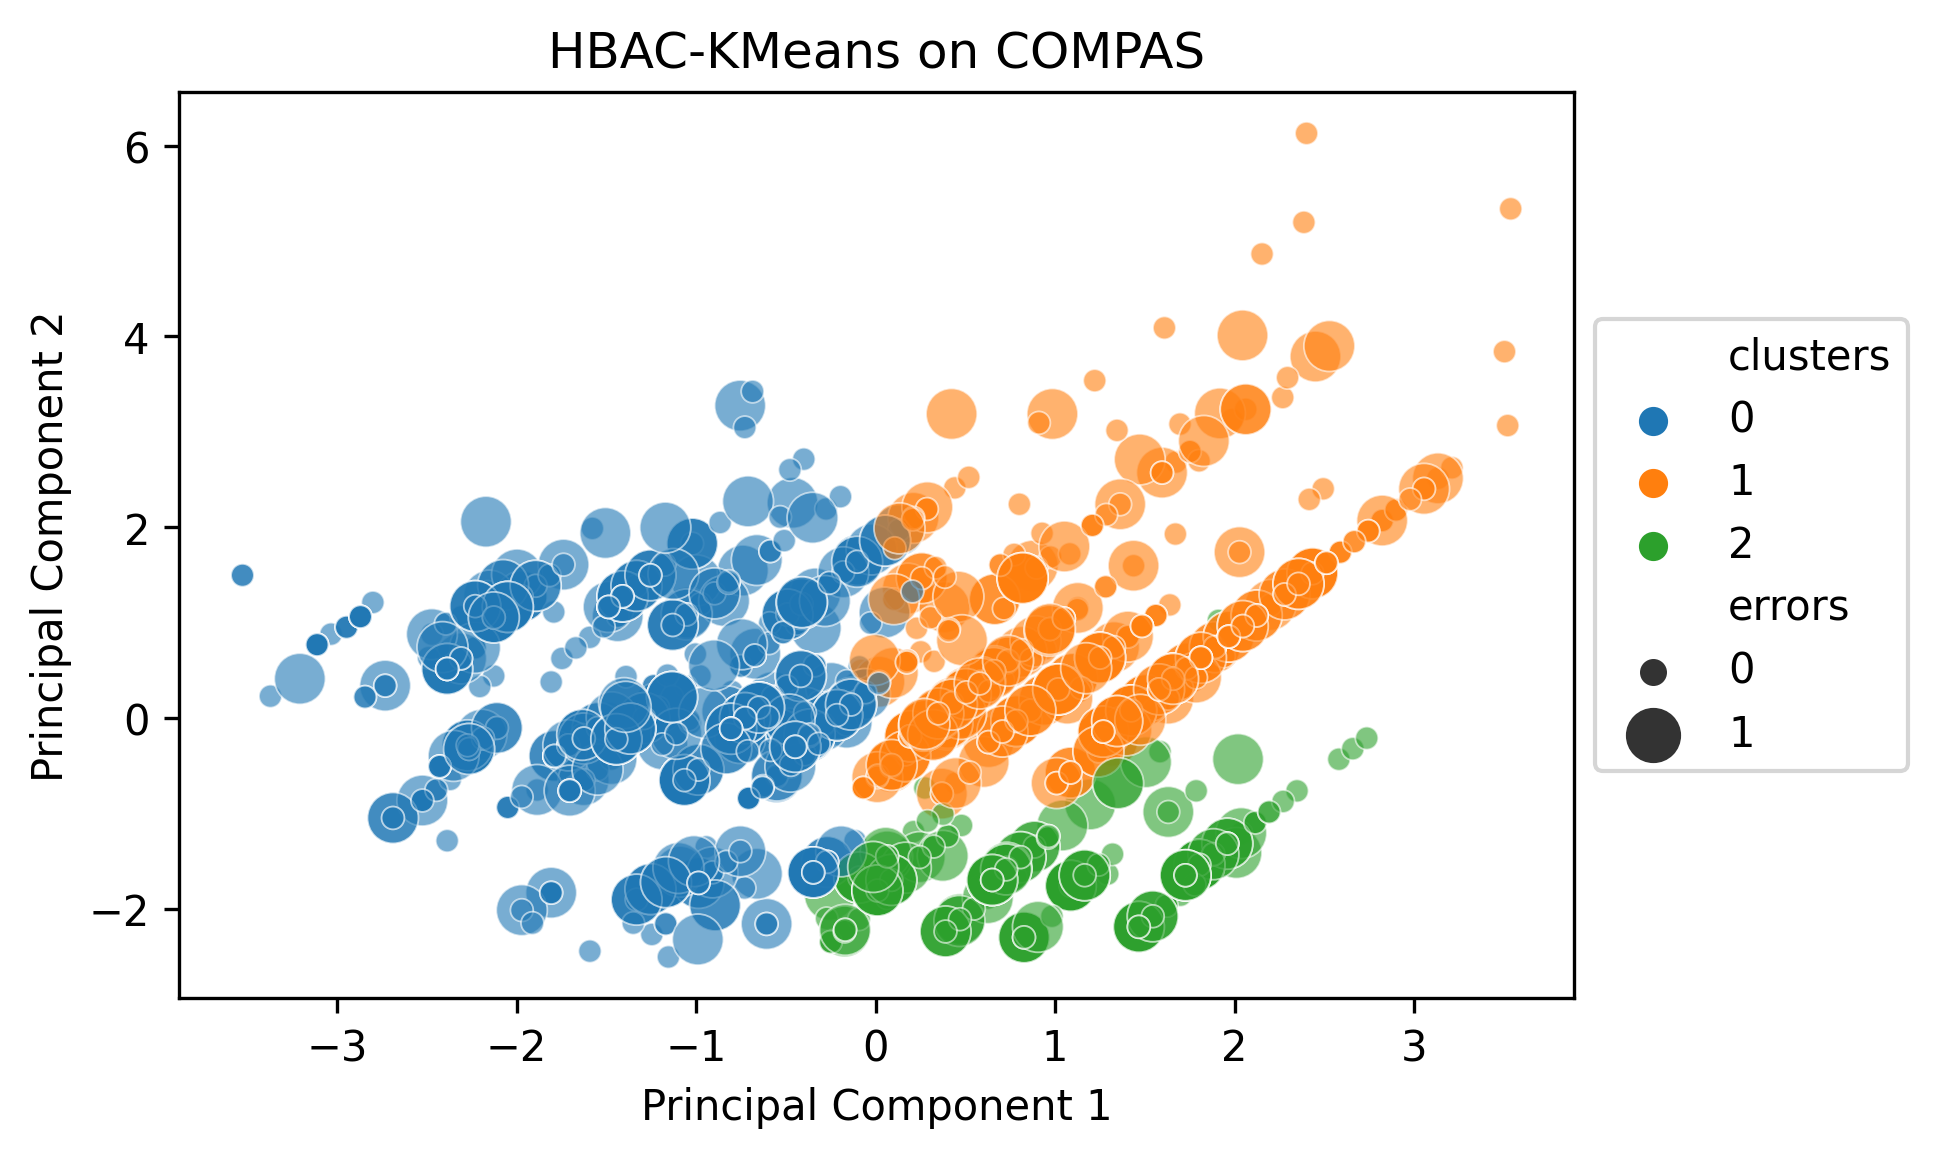

--> Cluster with the highest variance: 2
discriminating bias is: -999999
This is the random cluster we have picked: 0
discriminating bias is: -999999


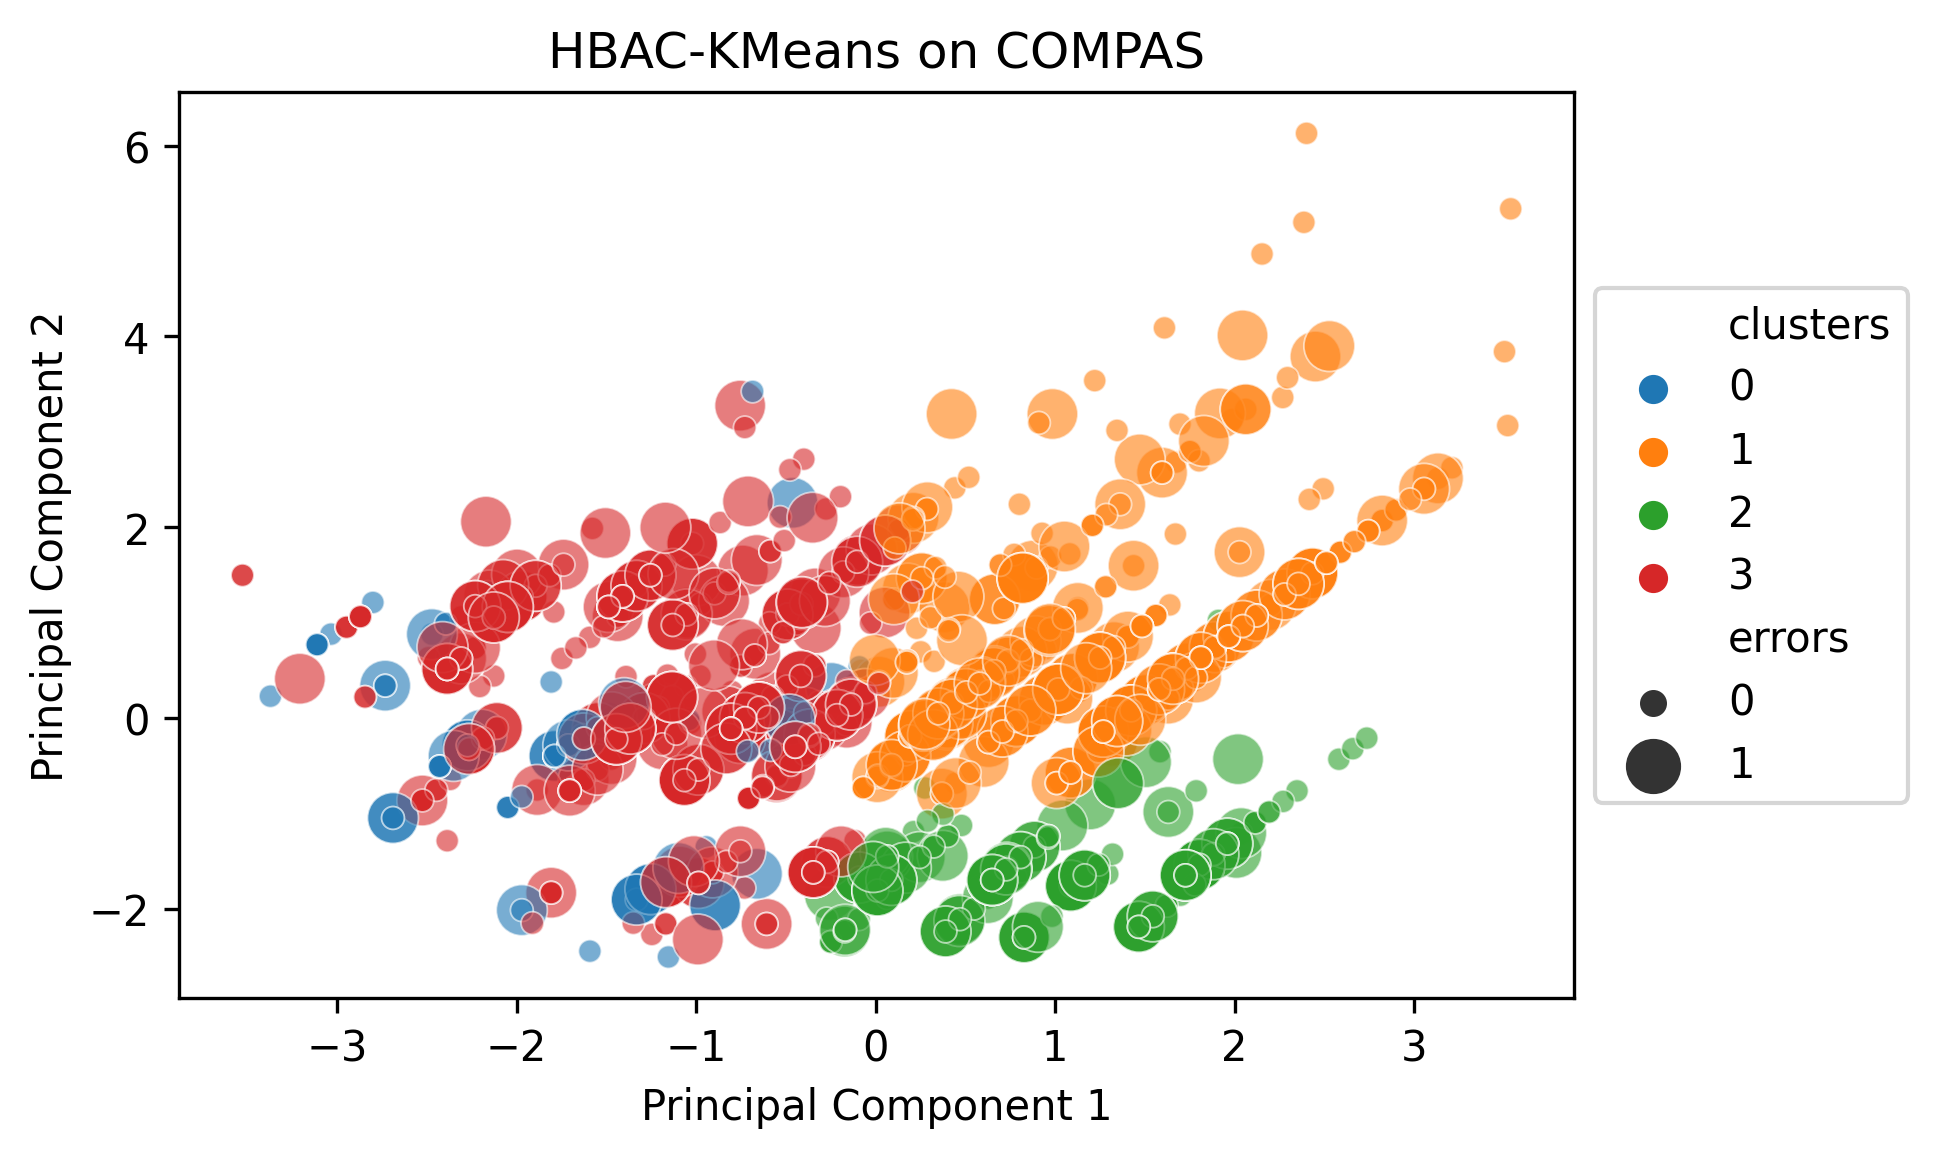

--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 0
This is the random cluster we have picked: 2
discriminating bias is: -999999
This is the random cluster we have picked: 3
discriminating bias is: -999999
This is the random cluster we have picked: 2
discriminating bias is: -999999
This is the random cluster we have picked: 1
discriminating bias is: -999999
This is the random cluster we have picked: 4
This is the random cluster we have picked: 0
This is the random cluster we have picked: 0
This is the random cluster we have picked: 2
discriminating bias is: -999999


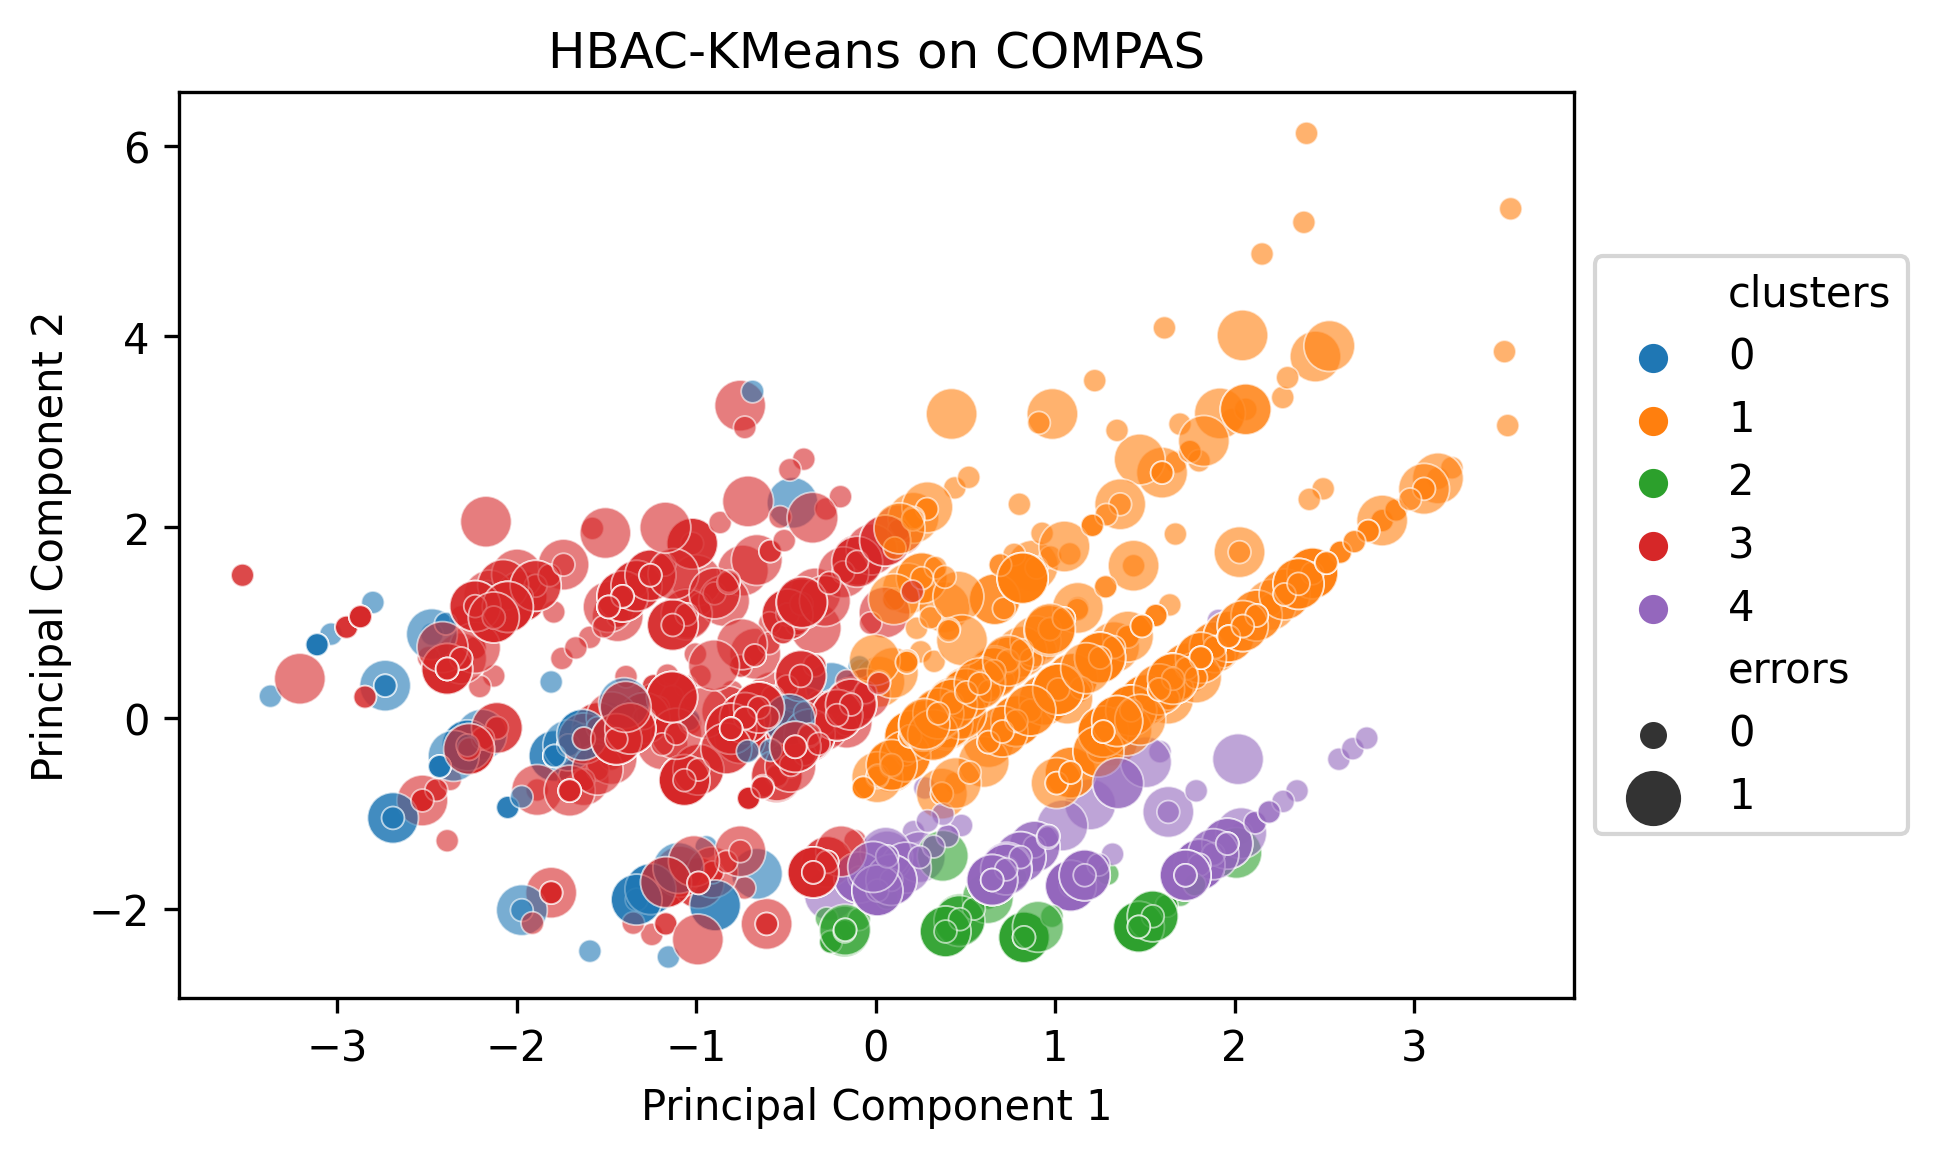

--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 2
This is the random cluster we have picked: 4
discriminating bias is: -999999
This is the random cluster we have picked: 1
discriminating bias is: -999999
This is the random cluster we have picked: 0
This is the random cluster we have picked: 0
This is the random cluster we have picked: 2
This is the random cluster we have picked: 4
discriminating bias is: -999999
This is the random cluster we have picked: 4
discriminating bias is: -999999
This is the random cluster we have picked: 0
This is the random cluster we have picked: 0
This is the random cluster we have picked: 0
This is the random cluster we have picked: 5
This is the random cluster we have picked: 3
discriminating bias is: -999999


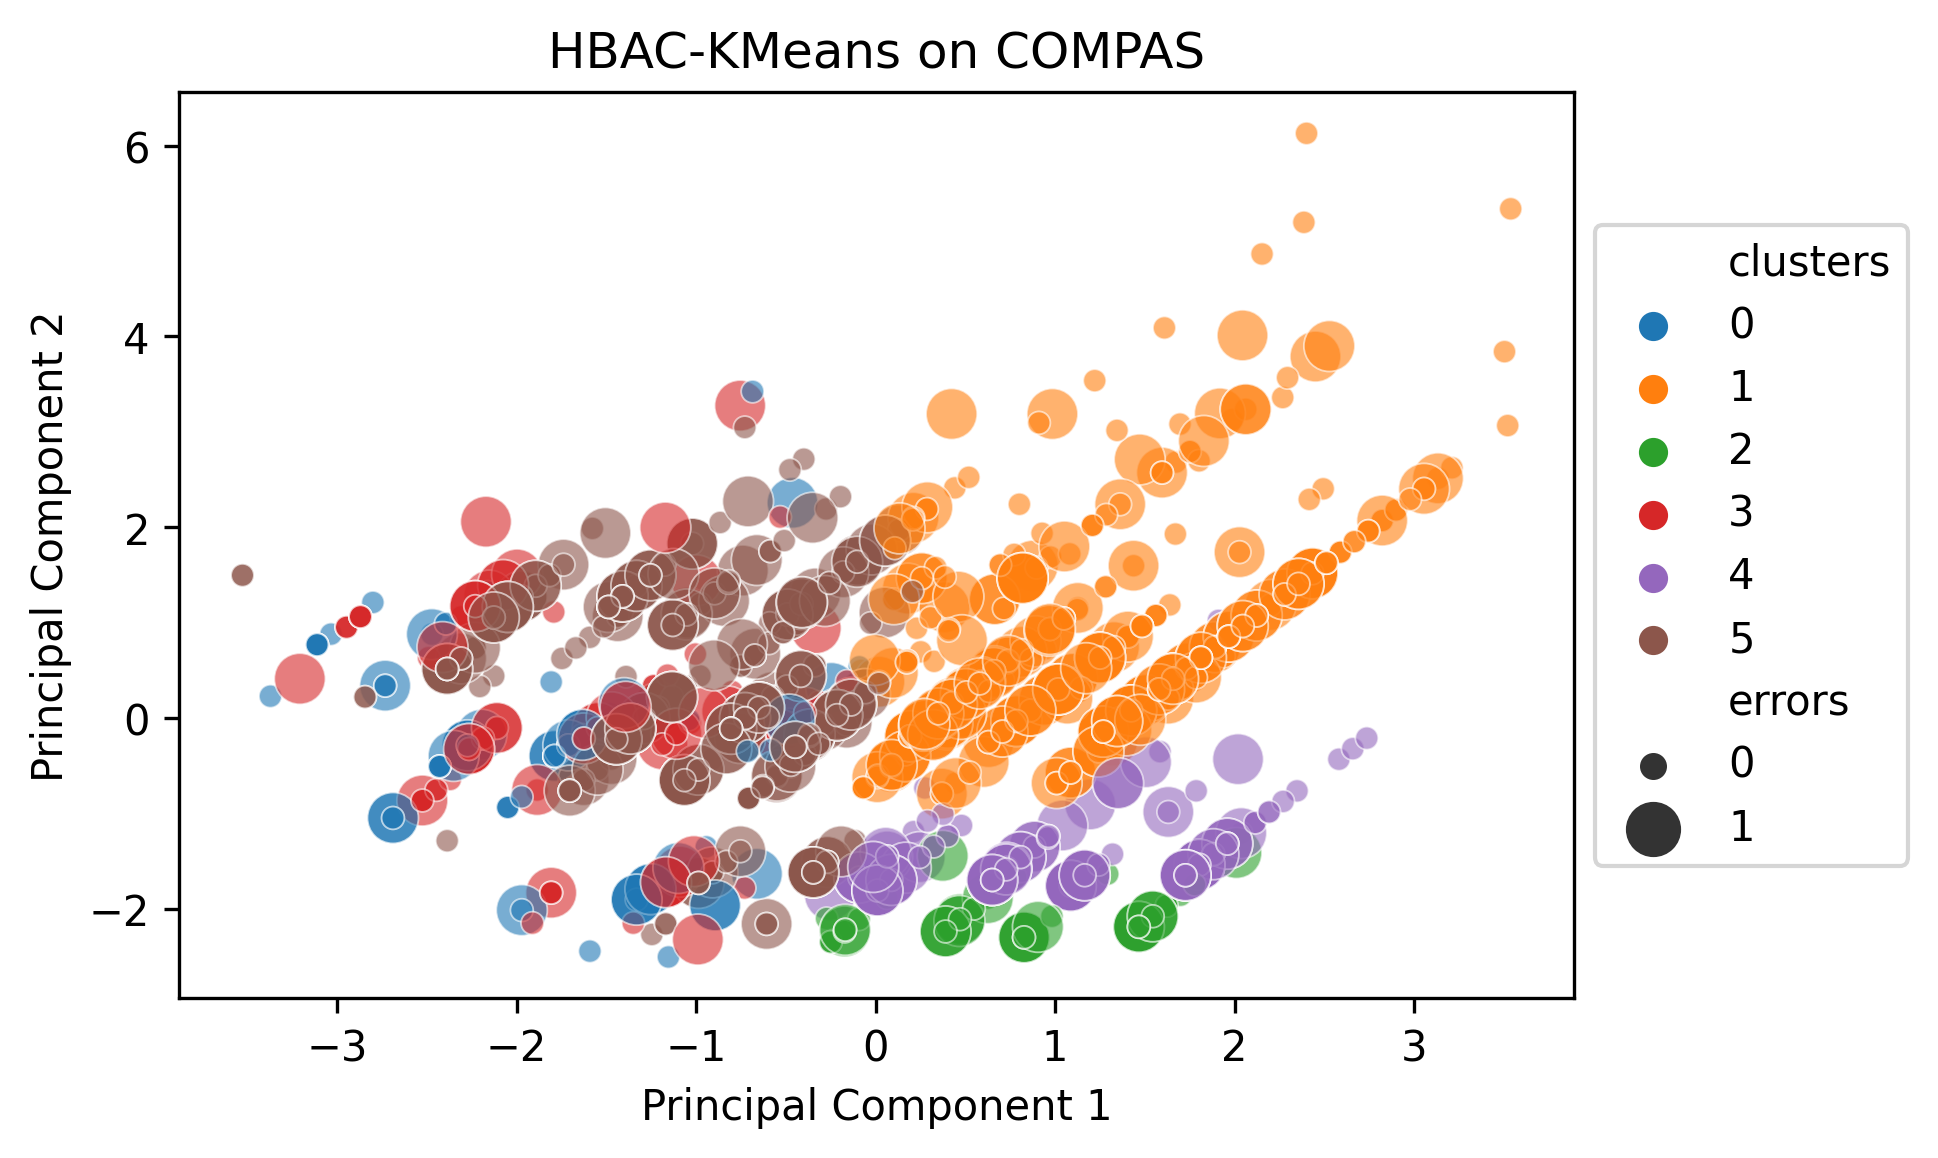

--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 3
--> Cluster with the highest variance: 2
This is the random cluster we have picked: 0
This is the random cluster we have picked: 6
This is the random cluster we have picked: 2
MAX_ITER
[0.001154761855224569, 0.0007130130016358944, 0.0007130130016358944, 0.0007060712902642484, 0.0007060712902642484, 0.0007060712902642484, 0.0007060712902642484, 0.0007060712902642484, 0.0007060712902642484, 0.0007060712902642484, 0.0007060712902642484, 0.0007060712902642484, 0.0008400580297267679, 0.0008400580297267679, 0.0008400580297267679, 0.0008400580297267679, 0.0008400580297267679, 0.0008400580297267679, 0.0008400580297267679, 0.0008400580297267679, 0.0008400580297267679, 0.0008400580297267679, 0.0008400580297267679, 0.0008400580297267679, 0.0008400580297267679, 0.001049164247086158, 0.001049164247086158, 0.001049164247086158]


In [21]:
# original code
MAX_ITER = 30
x = 0 # initial cluster number
initial_bias = 0
pca_plot(full_data, 'HBAC-KMeans on COMPAS', 0.6)
variance_list = []
average_accuracy = accuracy(full_data)
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.03 * len(full_data))
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data))
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x]

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply KMeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_negative_bias(full_data) # was get_max_abs_bias, but now it only finds the discriminated clusters
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #abs: >
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data, 'HBAC-KMeans on COMPAS', 0.6)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(variance_list)

## Analysing the biased cluster

In [22]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest discrimination bias")
print(most_biased_cluster_kmeans_aware)

4 has bias -0.013129551248429516
0 has bias -0.022165996418260447
3 has bias -0.03691592959885648
1 has bias -0.02284658895320557
5 has bias 0.05215060158521245
2 has bias -0.049496644295301984
cluster with the highest discriminating bias: 2
General accuracy of classifier on this dataset: 0.6727861771058316
cluster 2 has the highest discrimination bias
-0.049496644295301984


Number of instances in discriminated cluster: 64
Number of errors in discriminated clusters:  24
found discriminated cluster:


Number_of_Priors  score_factor  Age_Above_FourtyFive  \
4952         -0.467293      1.125535             -0.497974   
1248         -0.467293      1.125535             -0.497974   
501          -0.672808      1.125535             -0.497974   
3522         -0.672808      1.125535             -0.497974   
938          -0.261777      1.125535             -0.497974   
...                ...           ...                   ...   
678          -0.467293      1.125535             -0.497974   
3046          0.149254      1.125535             -0.497974   
5613         -0.672808      1.125535             -0.497974   
4901         -0.672808      1.125535             -0.497974   
4732         -0.672808      1.125535             -0.497974   

      Age_Below_TwentyFive  African_American     Asian  Hispanic  \
4952              1.899201         -1.031824 -0.065866  3.297240   
1248              1.899201          0.969158 -0.065866 -0.303284   
501               1.899201         -1.031824 -0.065866 -0.303284   
3522              1.899201          0.969158 -0.065866 -0.303284   
938               1.899201         -1.031824 -0.065866 -0.303284   
...                    ...               ...       ...       ...   
678               1.899201          0.969158 -0.065866 -0.303284   
3046              1.899201          0.969158 -0.065866 -0.303284   
5613              1.899201          0.969158 -0.065866 -0.303284   
4901              1.899201         -1.031824 -0.065866 -0.303284   
4732              1.899201          0.969158 -0.065866 -0.303284   

      Native_American     Other    Female  Misdemeanor  scaled_errors  \
4952         -0.04028 -0.231235  2.097479    -0.751125            0.0   
1248         -0.04028 -0.231235  2.097479    -0.751125            0.8   
501          -0.04028 -0.231235  2.097479    -0.751125            0.0   
3522         -0.04028 -0.231235  2.097479     1.331336            0.0   
938          -0.04028 -0.231235  2.097479    -0.751125            0.0   
...               ...       ...       ...          ...            ...   
678          -0.04028 -0.231235  2.097479     1.331336            0.8   
3046         -0.04028 -0.231235  2.097479    -0.751125            0.0   
5613         -0.04028 -0.231235  2.097479    -0.751125            0.0   
4901         -0.04028 -0.231235  2.097479     1.331336            0.0   
4732         -0.04028 -0.231235  2.097479     1.331336            0.0   

      predicted_class  true_class  errors  clusters  new_clusters  
4952                0           0       0         2            -1  
1248                1           0       1         2            -1  
501                 0           0       0         2            -1  
3522                0           0       0         2            -1  
938                 0           0       0         2            -1  
...               ...         ...     ...       ...           ...  
678                 0           1       1         2            -1  
3046                1           1       0         2            -1  
5613                0           0       0         2            -1  
4901                0           0       0         2            -1  
4732                0           0       0         2            -1  

[64 rows x 17 columns]

Number_of_Priors
this is the t-statistic -10.254704339130775
this is the p-value: 9.576571579452911e-18
score_factor
this is the t-statistic 7.609491469859682
this is the p-value: 9.313481272539696e-11
Age_Above_FourtyFive
this is the t-statistic -21.519987433893398
this is the p-value: 1.5754574325628678e-91
Age_Below_TwentyFive
this is the t-statistic 87.55640616399826
this is the p-value: 0.0
African_American
this is the t-statistic 5.150750018693346
this is the p-value: 2.3044688566344813e-06
Asian
this is the t-statistic -2.833983181699797
this is the p-value: 0.004648827099132375
Hispanic
this is the t-statistic -4.184248570000217
this is the p-value: 6.763818142286446e-05
Native_American
this is the t-statistic -1.7330208725049494
this is the p-value: 0.08326446835511757
Other
this is the t-statistic -9.957939882627391
this is the p-value: 9.014072800369432e-23
Female
this is the t-statistic 98.31160685804475
this is the p-value: 0.0
Misdemeanor
this is the t-statistic 0.4960222

unscaled_discriminated  unscaled_remaining  difference
Number_of_Priors                    0.953125            3.356823   -2.403698
score_factor                        0.812500            0.427852    0.384648
Age_Above_FourtyFive                0.000000            0.205817   -0.205817
Age_Below_TwentyFive                1.000000            0.189038    0.810962
African_American                    0.781250            0.506152    0.275098
Asian                               0.000000            0.004474   -0.004474
Hispanic                            0.015625            0.086689   -0.071064
Native_American                     0.000000            0.001678   -0.001678
Other                               0.000000            0.052573   -0.052573
Female                              1.000000            0.156040    0.843960
Misdemeanor                         0.390625            0.359620    0.031005
predicted_class                     0.281250            0.418904   -0.137654
true_class                          0.437500            0.455817   -0.018317
errors                              0.375000            0.325503    0.049497

Number_of_Priors  score_factor  Age_Above_FourtyFive  \
unscaled_discriminated          0.953125      0.812500              0.000000   
unscaled_remaining              3.356823      0.427852              0.205817   

                        Age_Below_TwentyFive  African_American     Asian  \
unscaled_discriminated              1.000000          0.781250  0.000000   
unscaled_remaining                  0.189038          0.506152  0.004474   

                        Hispanic  Native_American     Other   Female  \
unscaled_discriminated  0.015625         0.000000  0.000000  1.00000   
unscaled_remaining      0.086689         0.001678  0.052573  0.15604   

                        Misdemeanor  predicted_class  true_class    errors  \
unscaled_discriminated     0.390625         0.281250    0.437500  0.375000   
unscaled_remaining         0.359620         0.418904    0.455817  0.325503   

                                         index  
unscaled_discriminated  unscaled_discriminated  
unscaled_remaining          unscaled_remaining

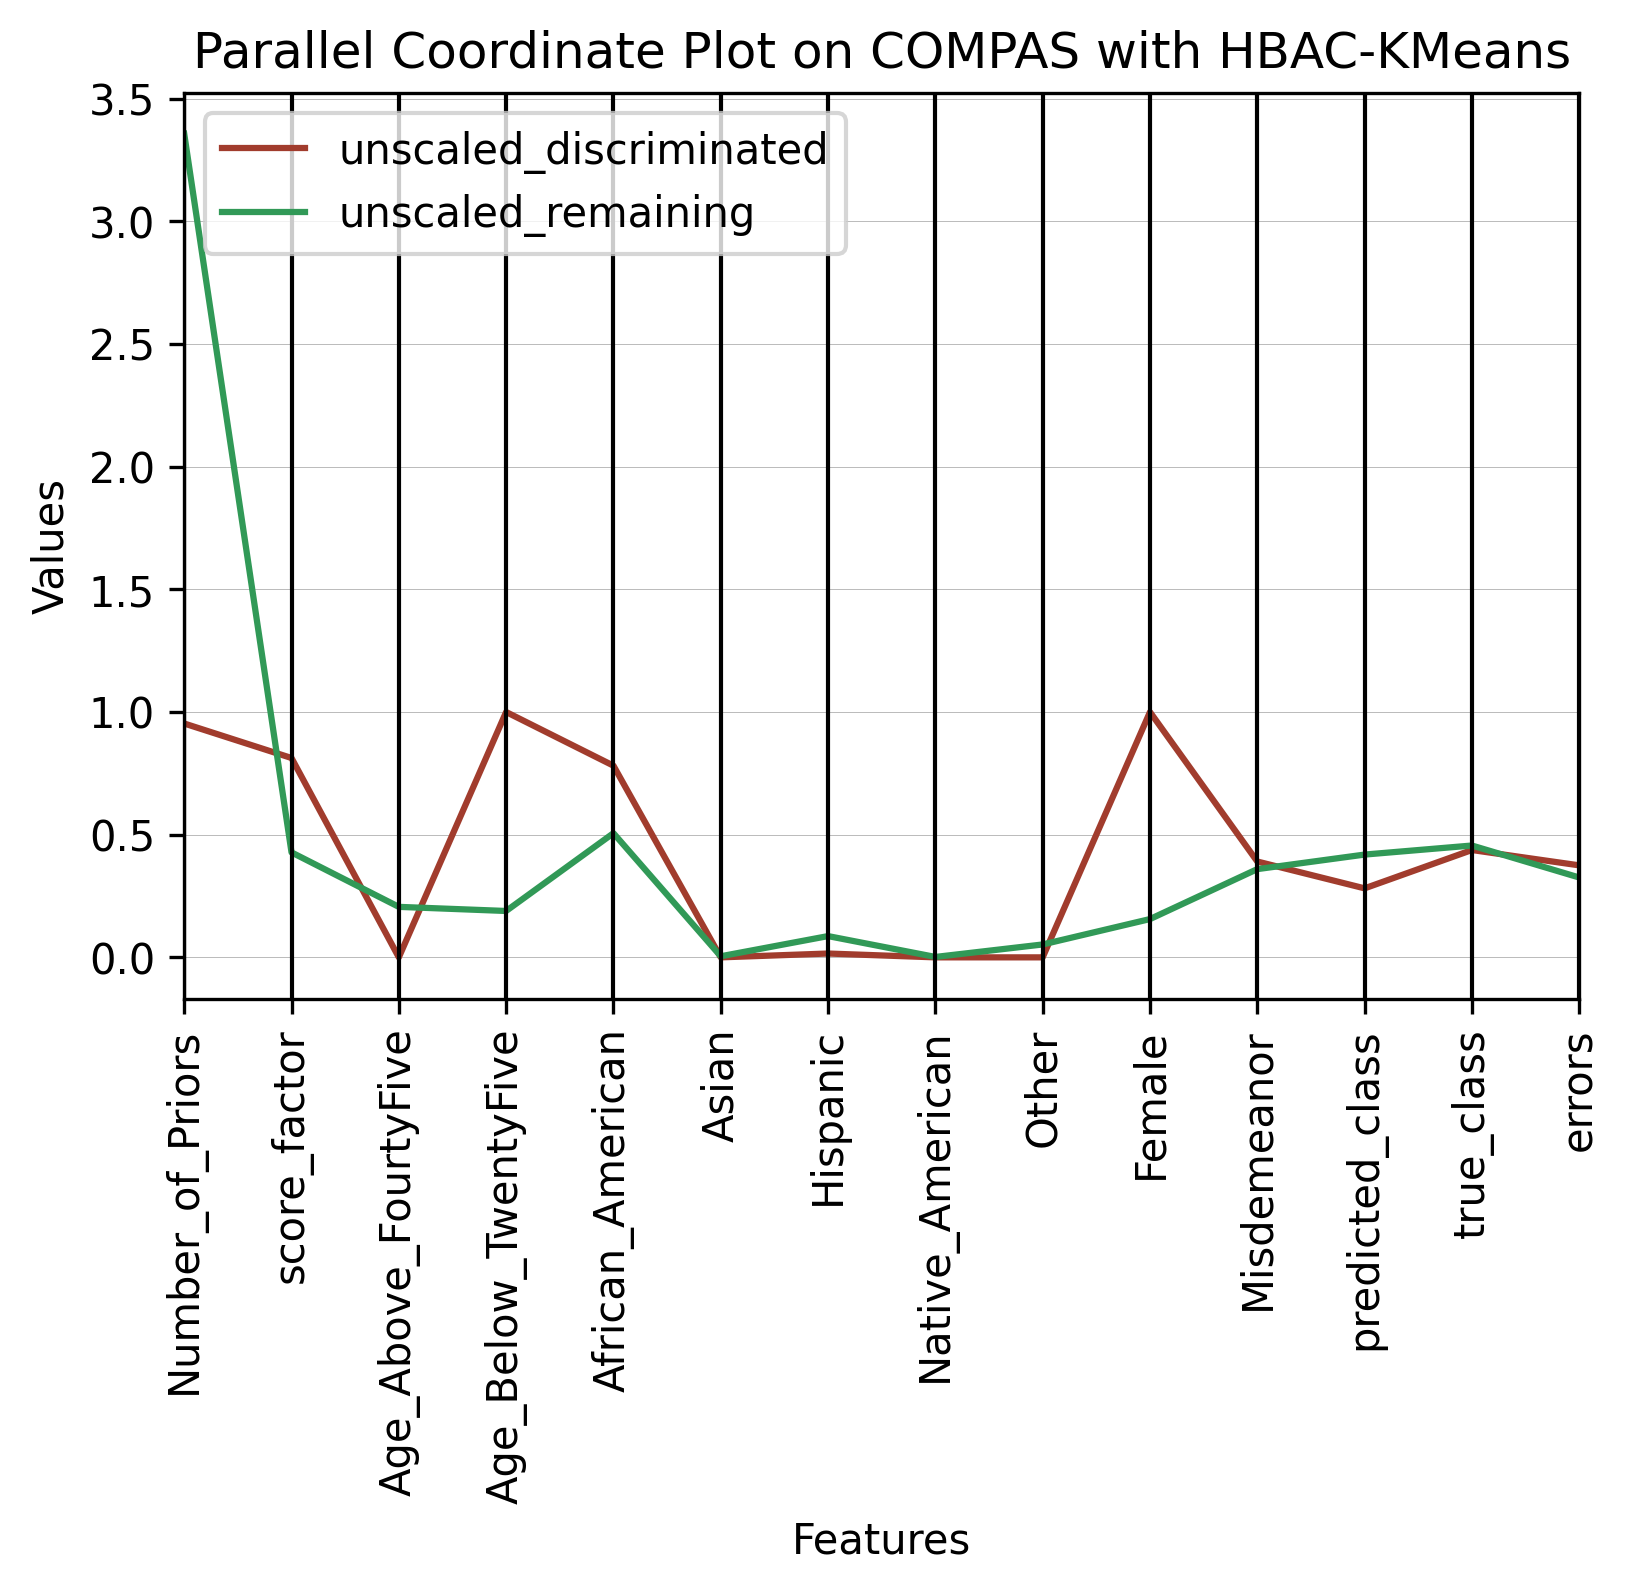

In [23]:
discriminated_cluster = full_data[full_data['clusters']==c]

# results 
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)

# unscaling the clusters
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]
# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

# Welch's test 
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the t-statistic', welch_i.statistic)
    print('this is the p-value:', welch_i.pvalue)


# Creating DF with mean difference between features
mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
display(mean_clusters)


# creating df for parallel coordinate plot
df_parallel = pd.DataFrame()
df_parallel['unscaled_discriminated'] = unscaled_discriminated.mean()
df_parallel['unscaled_remaining'] = unscaled_remaining.mean()
# df_parallel['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
df_parallel_transpose = df_parallel.T
df_parallel_transpose['index'] = df_parallel_transpose.index
display(df_parallel_transpose.head())

# create parallel coordinate plot
def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(df_parallel_transpose, "Parallel Coordinate Plot on COMPAS with HBAC-KMeans")

In [19]:
# altered for wine
discriminated_cluster = full_data[full_data['clusters']==c]

# results 
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)

# unscaling the clusters
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]
# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

# wine alterations
unscaled_remaining['proline'] = unscaled_remaining['proline'].div(100).round(2)
unscaled_discriminated['proline'] = unscaled_discriminated['proline'].div(100).round(2)
unscaled_remaining['magnesium'] = unscaled_remaining['magnesium'].div(10).round(2)
unscaled_discriminated['magnesium'] = unscaled_discriminated['magnesium'].div(10).round(2)
unscaled_remaining['alcalinity_of_ash'] = unscaled_remaining['alcalinity_of_ash'].div(5).round(2)
unscaled_discriminated['alcalinity_of_ash'] = unscaled_discriminated['alcalinity_of_ash'].div(5).round(2)

# Welch's test 
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the t-statistic', welcthe h_i.statistic)
    print('this is the p-value:', welch_i.pvalue)


# Creating DF with mean difference between features
mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
display(mean_clusters)


# creating df for parallel coordinate plot
df_parallel = pd.DataFrame()
df_parallel['unscaled_discriminated'] = unscaled_discriminated.mean()
df_parallel['unscaled_remaining'] = unscaled_remaining.mean()
df_parallel = df_parallel.drop(['true_class', 'predicted_class', 'errors'])
# df_parallel['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
df_parallel_transpose = df_parallel.T
df_parallel_transpose['index'] = df_parallel_transpose.index
display(df_parallel_transpose.head())

# create parallel coordinate plot
def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper right")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(df_parallel_transpose, "Parallel Coordinate Plot on Wine with HBAC-KMeans")

SyntaxError: invalid syntax (<ipython-input-19-c2095a3e1c76>, line 27)

## Ridgeline / Density plot

In [23]:
column_names = unscaled_discriminated.iloc[: , : 12].columns
# column_names = unscaled_remaining.iloc[: , : ].columns
# full_data.iloc[: , : 24]
column_names

# not_discriminated = full_data[full_data['clusters']!=c]
# df = not_discriminated

# Let's grab only the subset of columns displayed in the example

# column_names = discriminated_cluster.iloc[: , : 14].columns
df = unscaled_discriminated[column_names]

# Not only does 'ridgeplot(...)' come configured with sensible defaults
# but is also fully configurable to your own style and preference!
fig = ridgeplot(
    samples=df.values.T,
    bandwidth=4,
    kde_points=np.linspace(-12.5, 112.5, 400),
    colorscale="viridis",
    colormode="index",
    coloralpha=0.6,
    labels=column_names,
    spacing=5 / 9,
)

# Again, update the figure layout to your liking here
fig.update_layout(
    title="HBAC-KMeans on COMPAS: Discriminated Cluster distribution",
    height=650,
    width=800,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_title="Assigned Probability (%)",
)
fig.show()

## Plotly 

In [30]:
# df with discriminated and remaining clusters 

df_all = raw_data.copy(deep=True)
df_all["bias"] = "remaining"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

discriminated = df_all.loc[discriminated_cluster.index]
discriminated["bias"] = "discriminated"
df_all["bias"] = discriminated["bias"].combine_first(df_all['bias'])

# check to find discriminated instances in df
df_all.loc[df_all['bias']=='discriminated']
# df_all.to_csv('compas_kmeans_results')



Number_of_Priors  score_factor  Age_Above_FourtyFive  \
4952                 1             1                     0   
1248                 1             1                     0   
501                  0             1                     0   
3522                 0             1                     0   
938                  2             1                     0   
...                ...           ...                   ...   
678                  1             1                     0   
3046                 4             1                     0   
5613                 0             1                     0   
4901                 0             1                     0   
4732                 0             1                     0   

      Age_Below_TwentyFive  African_American  Asian  Hispanic  \
4952                     1                 0      0         1   
1248                     1                 1      0         0   
501                      1                 0      0         0   
3522                     1                 1      0         0   
938                      1                 0      0         0   
...                    ...               ...    ...       ...   
678                      1                 1      0         0   
3046                     1                 1      0         0   
5613                     1                 1      0         0   
4901                     1                 0      0         0   
4732                     1                 1      0         0   

      Native_American  Other  Female  Misdemeanor  predicted_class  \
4952                0      0       1            0                0   
1248                0      0       1            0                1   
501                 0      0       1            0                0   
3522                0      0       1            1                0   
938                 0      0       1            0                0   
...               ...    ...     ...          ...              ...   
678                 0      0       1            1                0   
3046                0      0       1            0                1   
5613                0      0       1            0                0   
4901                0      0       1            1                0   
4732                0      0       1            1                0   

      true_class  errors           bias  
4952           0       0  discriminated  
1248           0       1  discriminated  
501            0       0  discriminated  
3522           0       0  discriminated  
938            0       0  discriminated  
...          ...     ...            ...  
678            1       1  discriminated  
3046           1       0  discriminated  
5613           0       0  discriminated  
4901           0       0  discriminated  
4732           0       0  discriminated  

[64 rows x 15 columns]

In [27]:
df_all.columns
welchtest = pd.DataFrame()
welchtest = df_all[['Age_Below_TwentyFive', 'Hispanic', 'Female', 'bias']]
# welchtest = df_all
welchtest.columns

Index(['Age_Below_TwentyFive', 'Hispanic', 'Female', 'bias'], dtype='object')

In [32]:
df_all.to_csv('compas_kmeans')

1
2
3
4
5


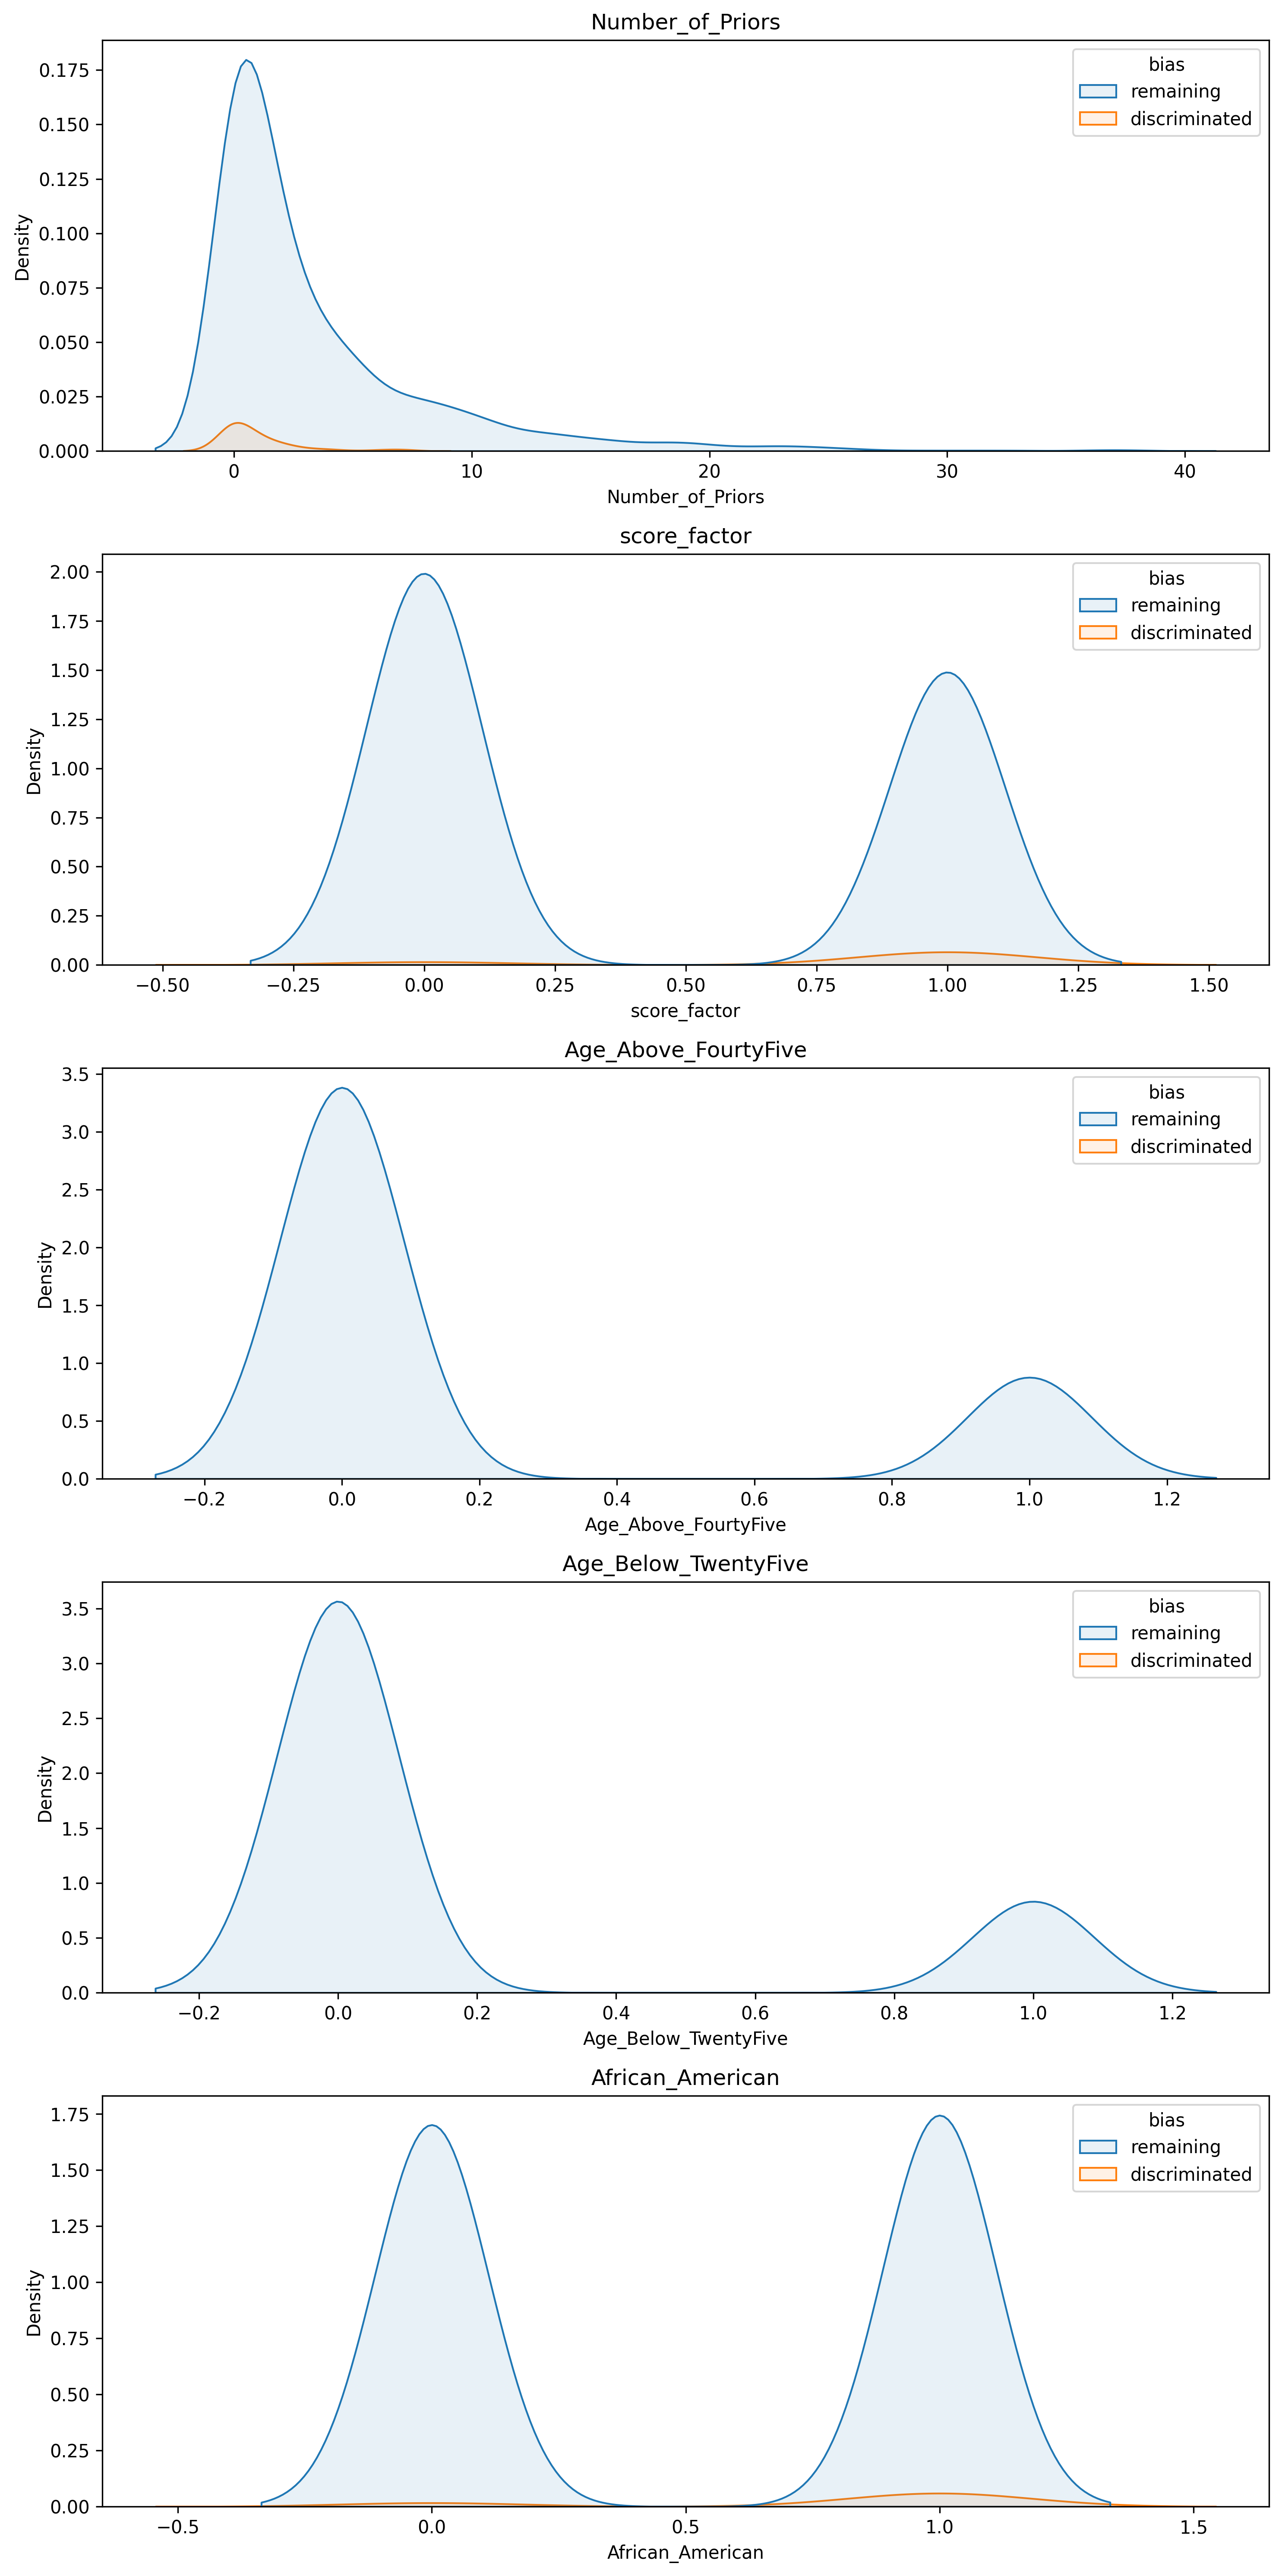

In [28]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,20))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in df_all.columns:
    sns.kdeplot(data=df_all, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 5: 
        break

plt.tight_layout()   
plt.show()

In [50]:
df_all

Index(['Age_Below_TwentyFive', 'Hispanic', 'Female', 'bias'], dtype='object')

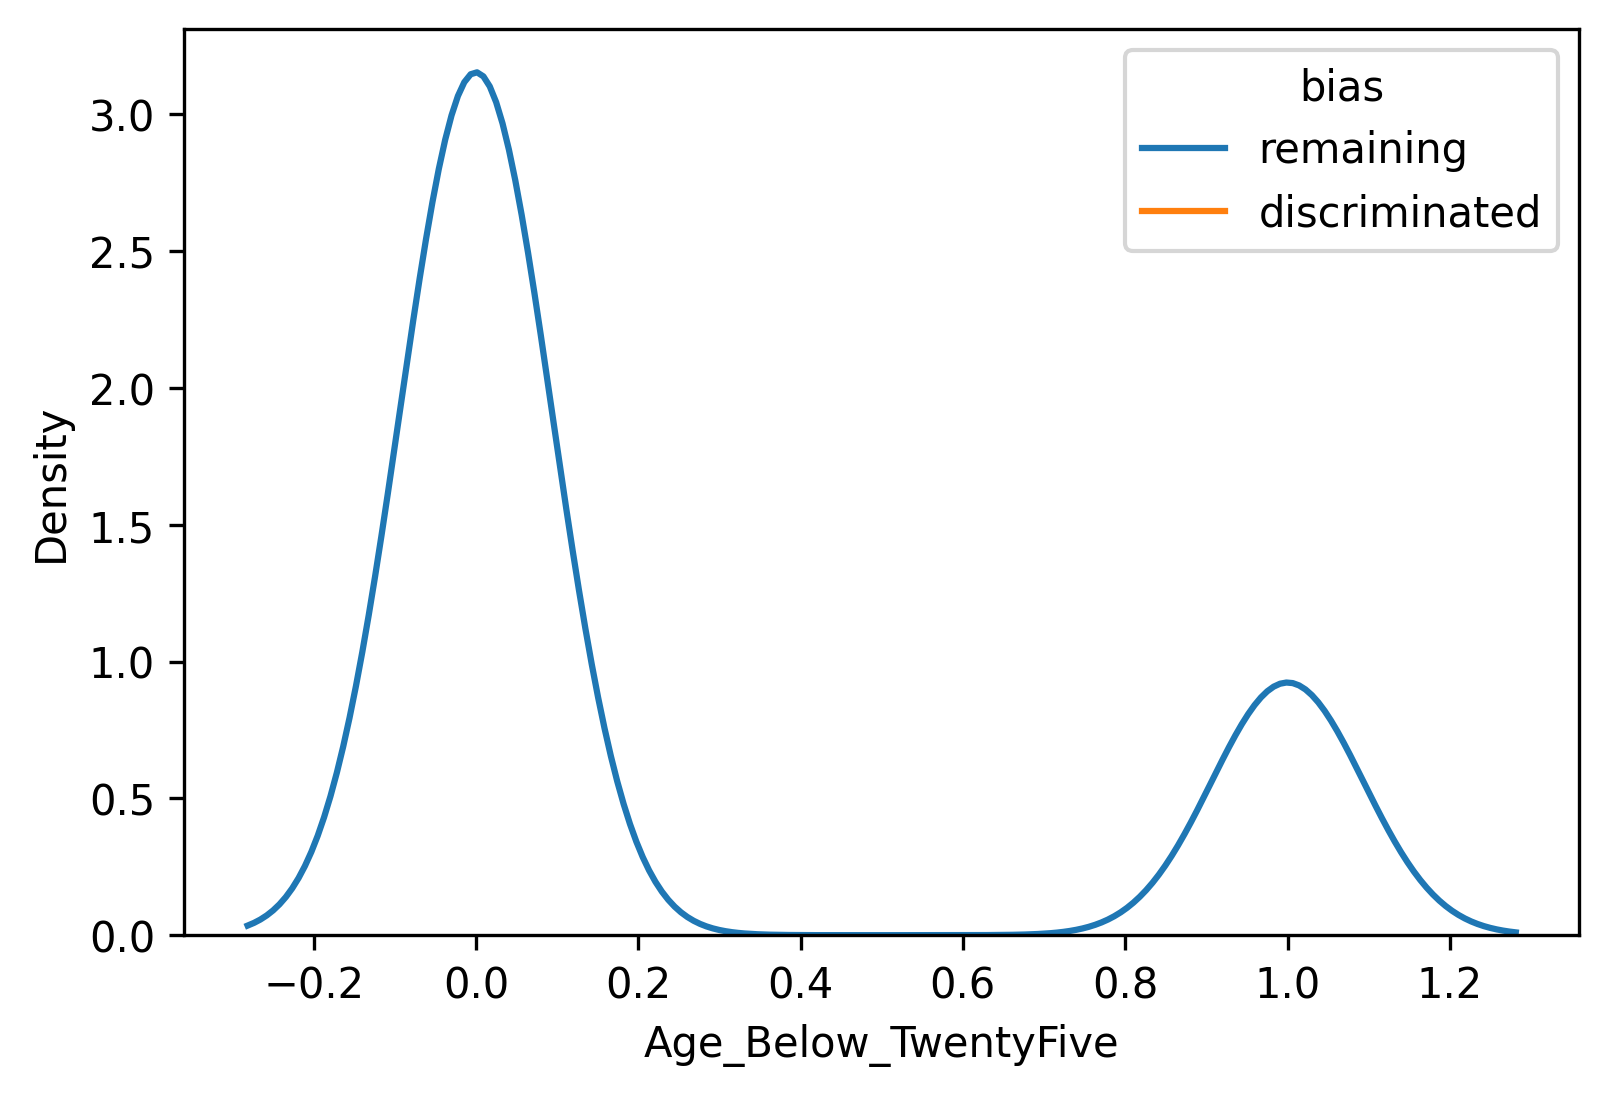

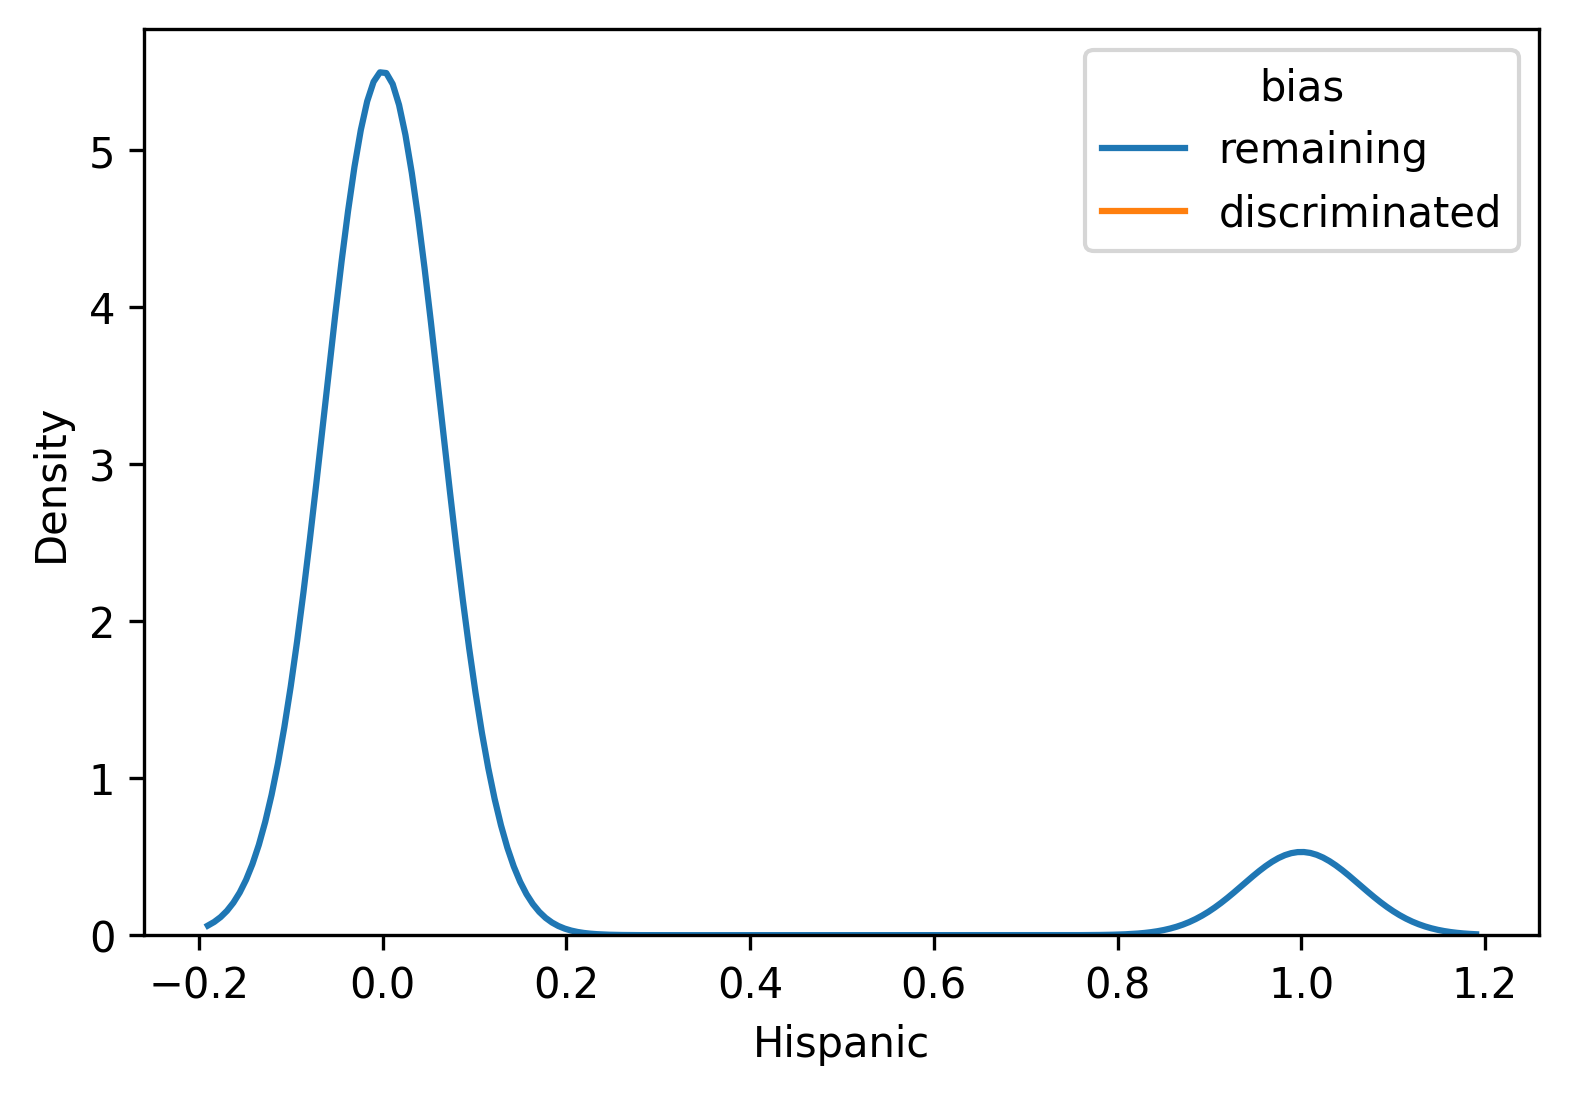

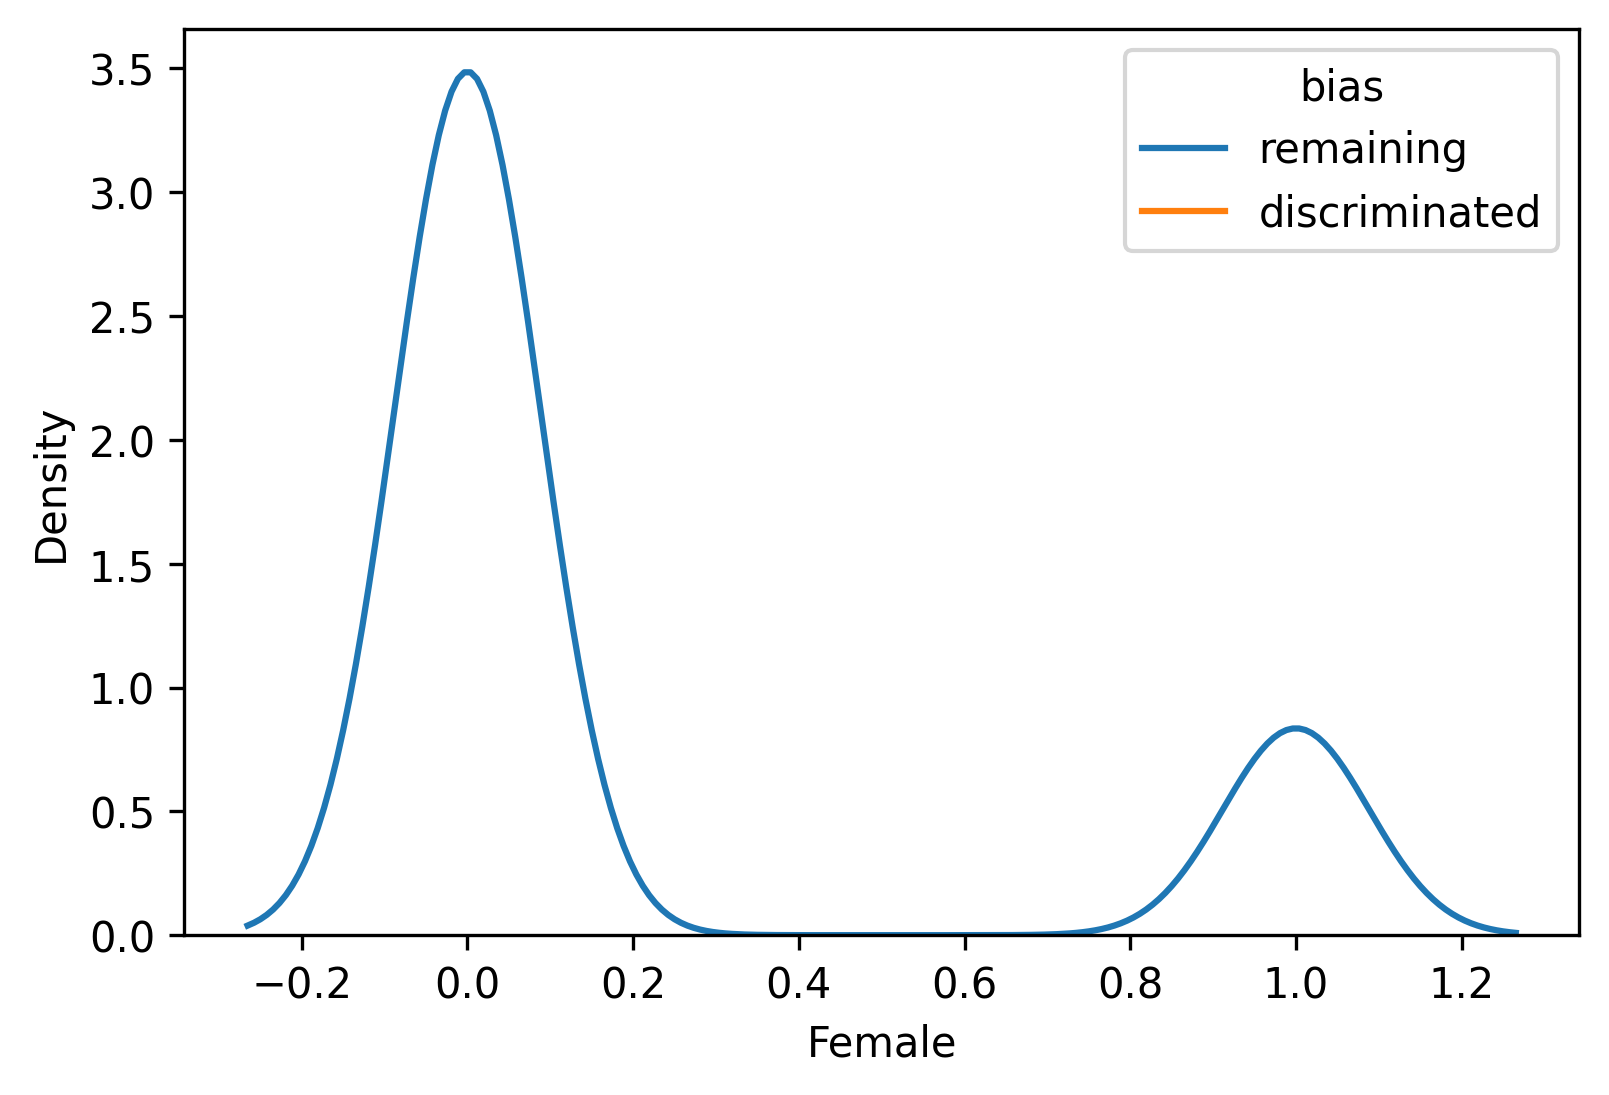

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

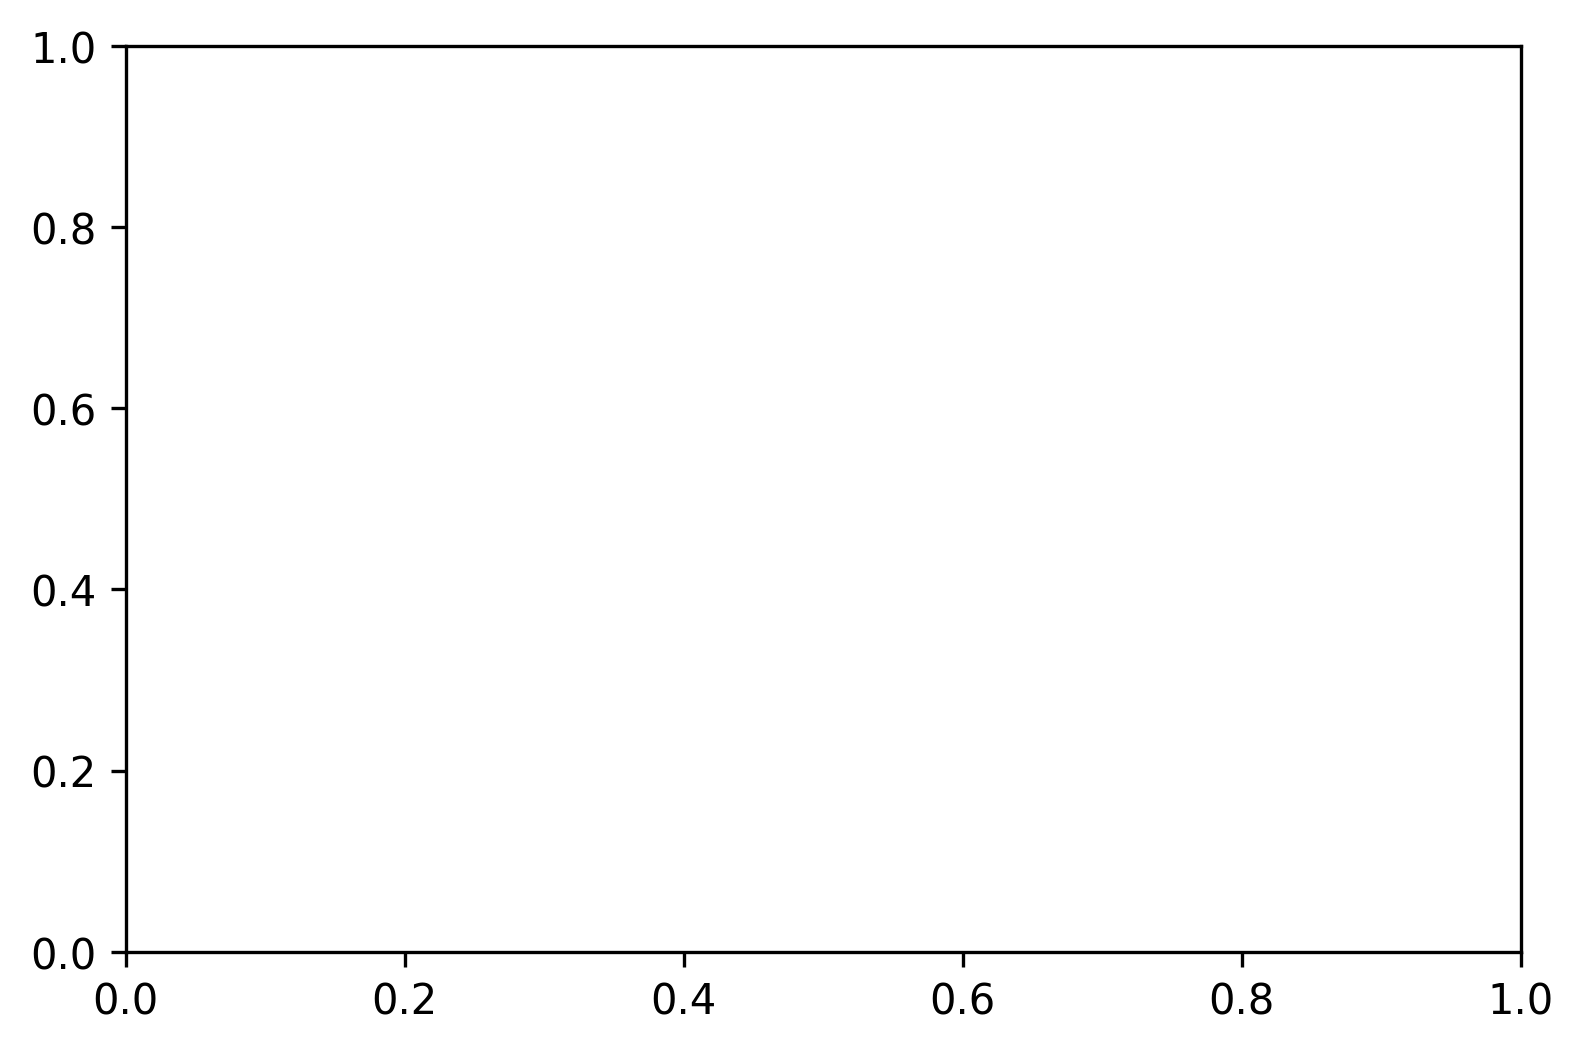

In [54]:
for i in df_all.columns:
    sns.kdeplot(data=df_all, x=i, hue='bias')

    # ax[i].set_title(col) 
    plt.show()

In [42]:
df_all.info()
df_all['bias']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852 entries, 4590 to 1754
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Number_of_Priors      1852 non-null   int64 
 1   score_factor          1852 non-null   int64 
 2   Age_Above_FourtyFive  1852 non-null   int64 
 3   Age_Below_TwentyFive  1852 non-null   int64 
 4   African_American      1852 non-null   int64 
 5   Asian                 1852 non-null   int64 
 6   Hispanic              1852 non-null   int64 
 7   Native_American       1852 non-null   int64 
 8   Other                 1852 non-null   int64 
 9   Female                1852 non-null   int64 
 10  Misdemeanor           1852 non-null   int64 
 11  predicted_class       1852 non-null   int64 
 12  true_class            1852 non-null   int64 
 13  errors                1852 non-null   int64 
 14  bias                  1852 non-null   object
dtypes: int64(14), object(1)
memory usag

4590    remaining
2482    remaining
4092    remaining
165     remaining
1109    remaining
          ...    
1263    remaining
2448    remaining
2877    remaining
5122    remaining
1754    remaining
Name: bias, Length: 1852, dtype: object

In [36]:
df_all.columns
welchtest = pd.DataFrame()
welchtest = df_all[['alcohol', 'total_phenols', 'flavanoids', 'od280/od315', 'proline', 'bias']]
welchtest.columns

Index(['alcohol', 'total_phenols', 'flavanoids', 'od280/od315', 'proline',
       'bias'],
      dtype='object')

1
2
3


TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

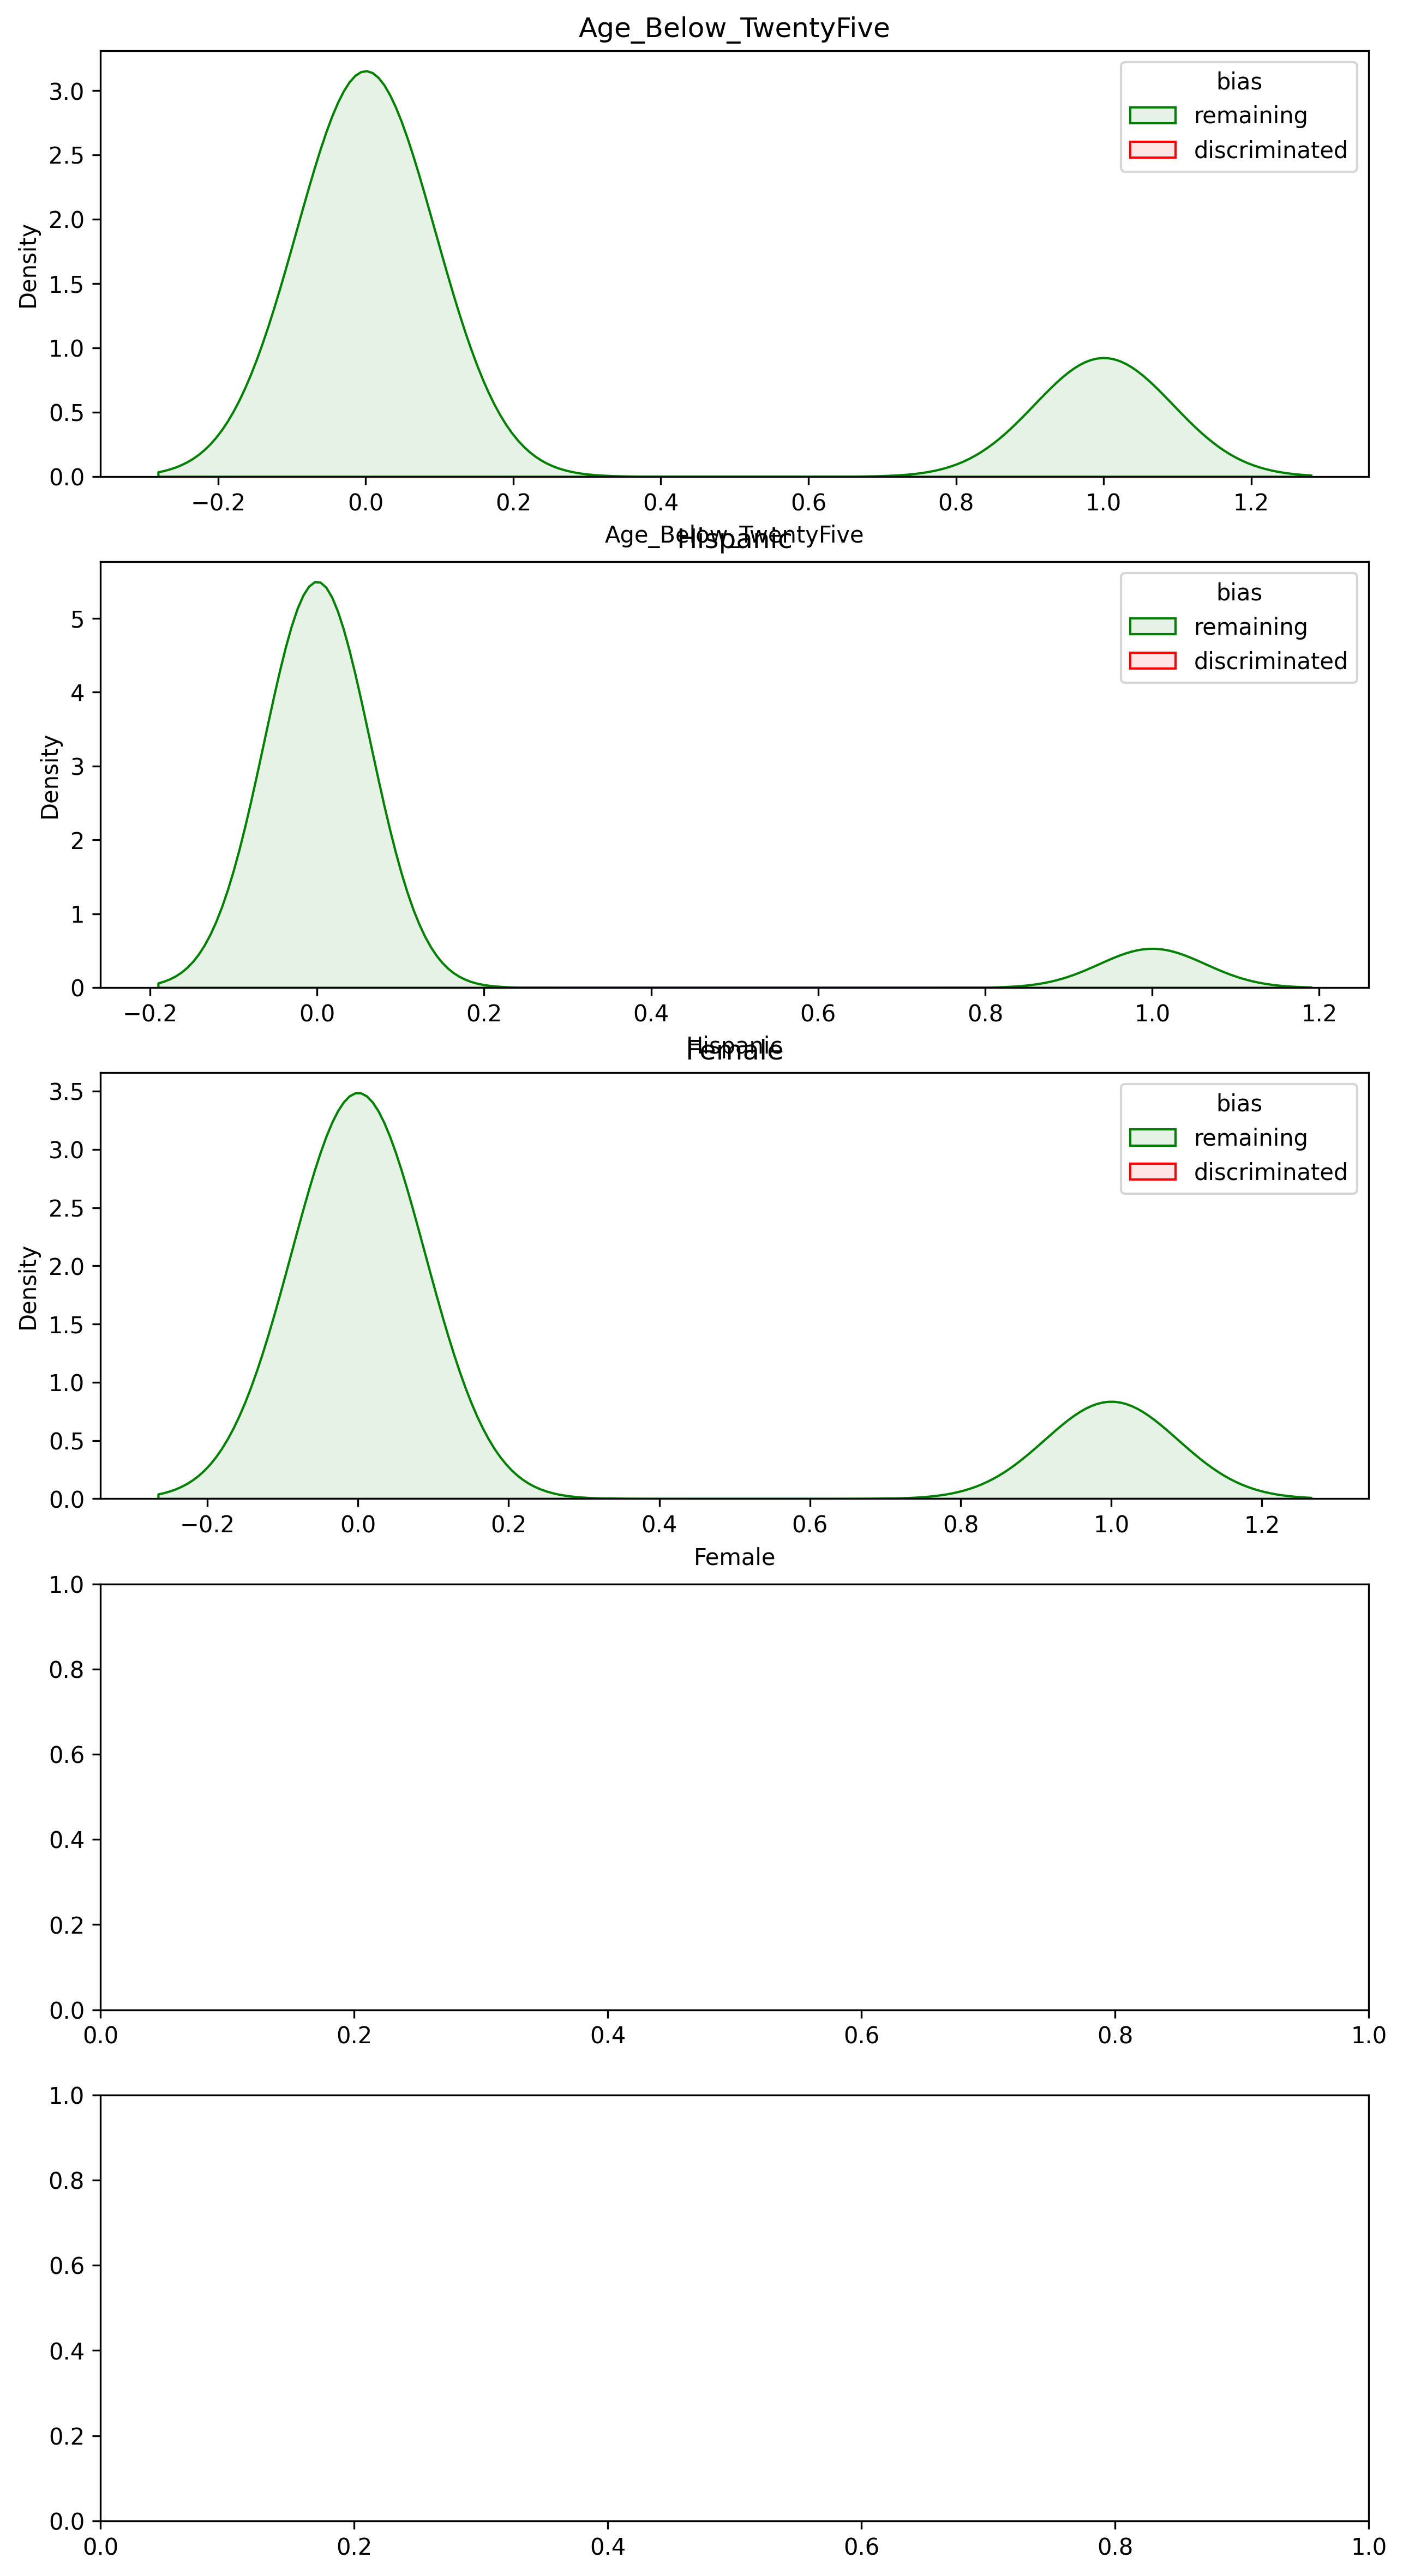

In [40]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,20))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in welchtest.columns:
    sns.kdeplot(data=welchtest, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 5: 
        break

plt.tight_layout()

plt.show()



In [39]:
df_all

Number_of_Priors  score_factor  Age_Above_FourtyFive  \
4590                 0             1                     0   
2482                 6             1                     0   
4092                 0             0                     1   
165                  0             0                     0   
1109                11             1                     0   
...                ...           ...                   ...   
1263                 0             0                     0   
2448                 1             1                     0   
2877                 9             1                     0   
5122                 5             0                     0   
1754                 0             0                     0   

      Age_Below_TwentyFive  African_American  Asian  Hispanic  \
4590                     1                 1      0         0   
2482                     1                 0      0         0   
4092                     0                 0      0         0   
165                      1                 1      0         0   
1109                     0                 0      0         1   
...                    ...               ...    ...       ...   
1263                     0                 0      0         1   
2448                     0                 0      0         0   
2877                     0                 0      0         0   
5122                     0                 1      0         0   
1754                     0                 0      0         0   

      Native_American  Other  Female  Misdemeanor  predicted_class  \
4590                0      0       0            1                0   
2482                0      0       0            0                1   
4092                0      1       1            0                0   
165                 0      0       0            0                0   
1109                0      0       0            1                1   
...               ...    ...     ...          ...              ...   
1263                0      0       0            1                0   
2448                0      0       0            0                0   
2877                0      0       0            0                1   
5122                0      0       0            0                0   
1754                0      0       0            0                0   

      true_class  errors       bias  
4590           1       1  remaining  
2482           0       1  remaining  
4092           1       1  remaining  
165            1       1  remaining  
1109           0       1  remaining  
...          ...     ...        ...  
1263           1       1  remaining  
2448           0       0  remaining  
2877           0       1  remaining  
5122           0       0  remaining  
1754           0       0  remaining  

[1852 rows x 15 columns]

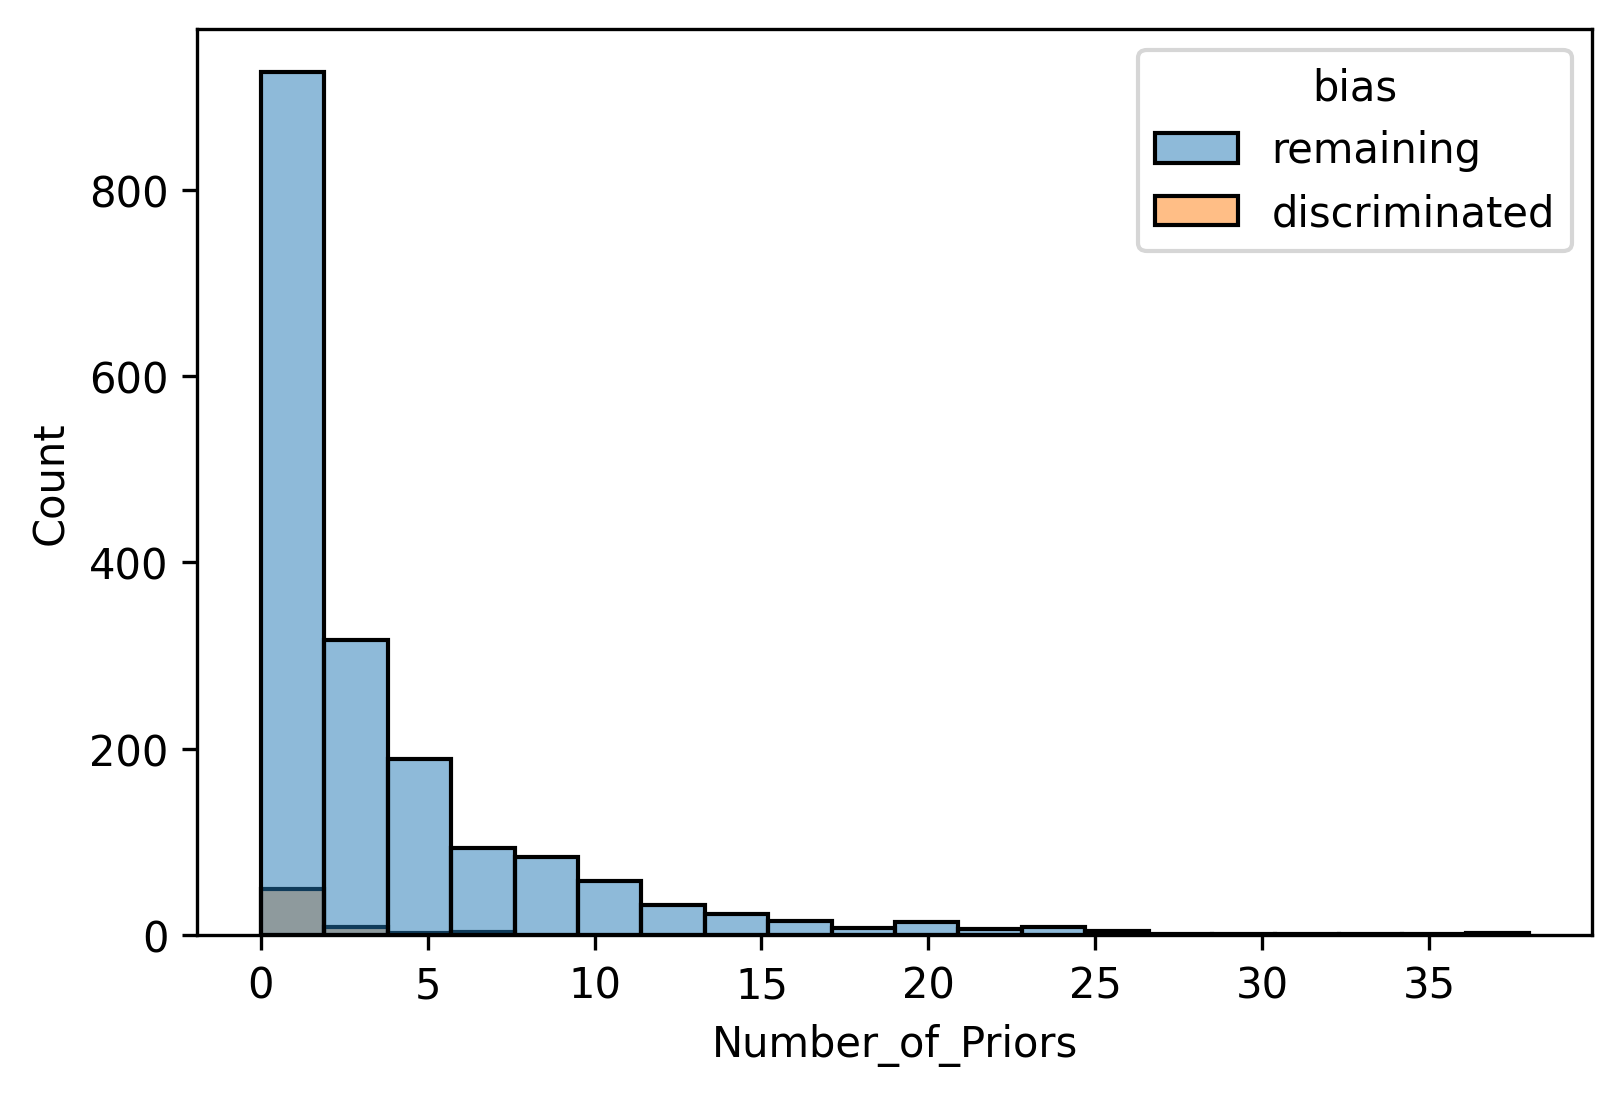

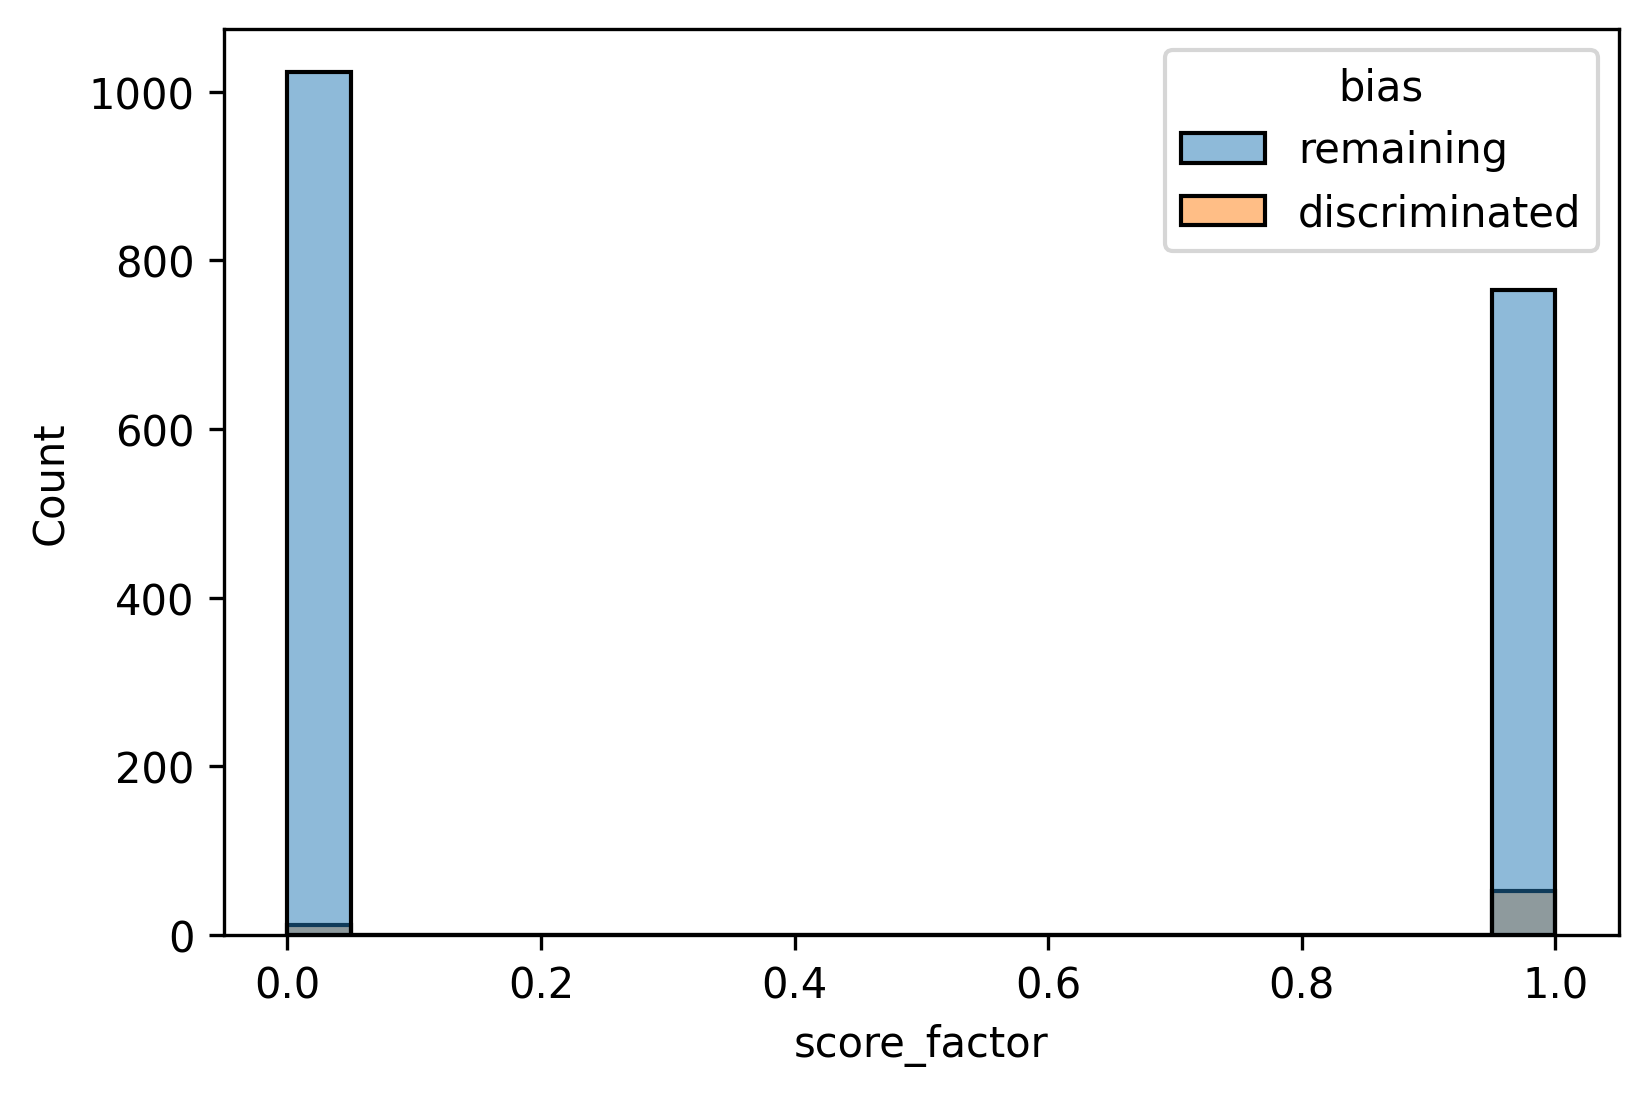

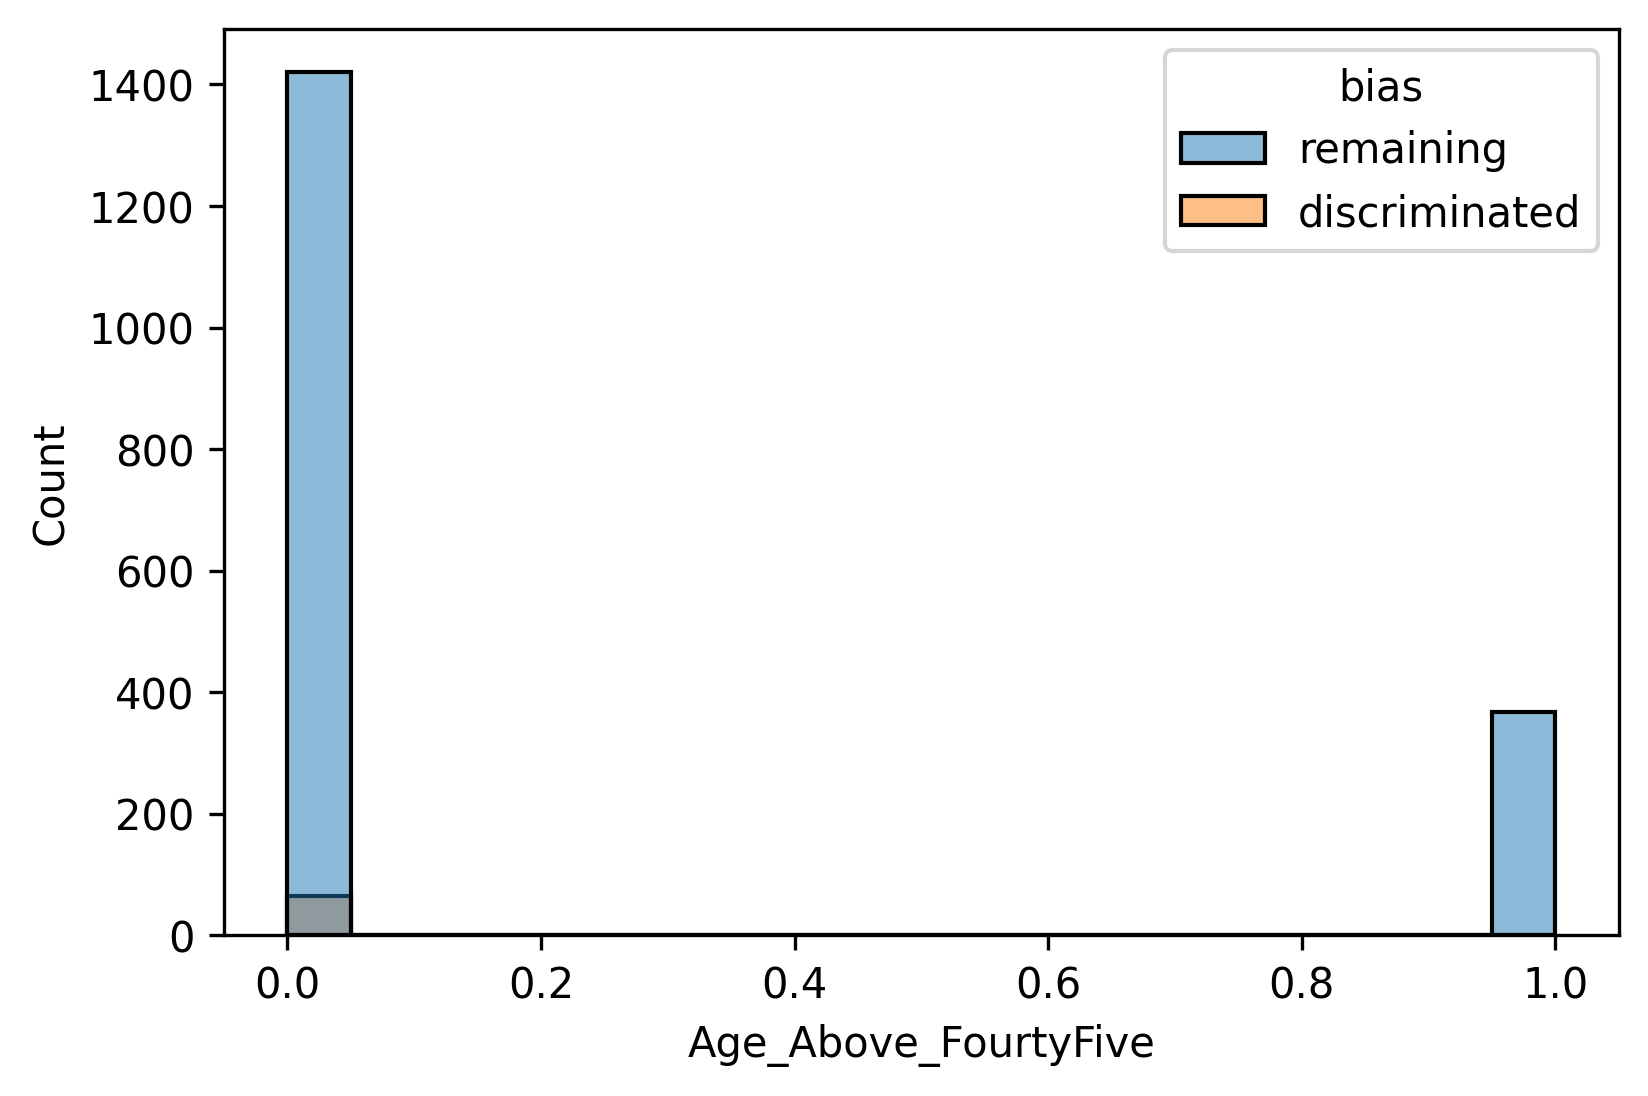

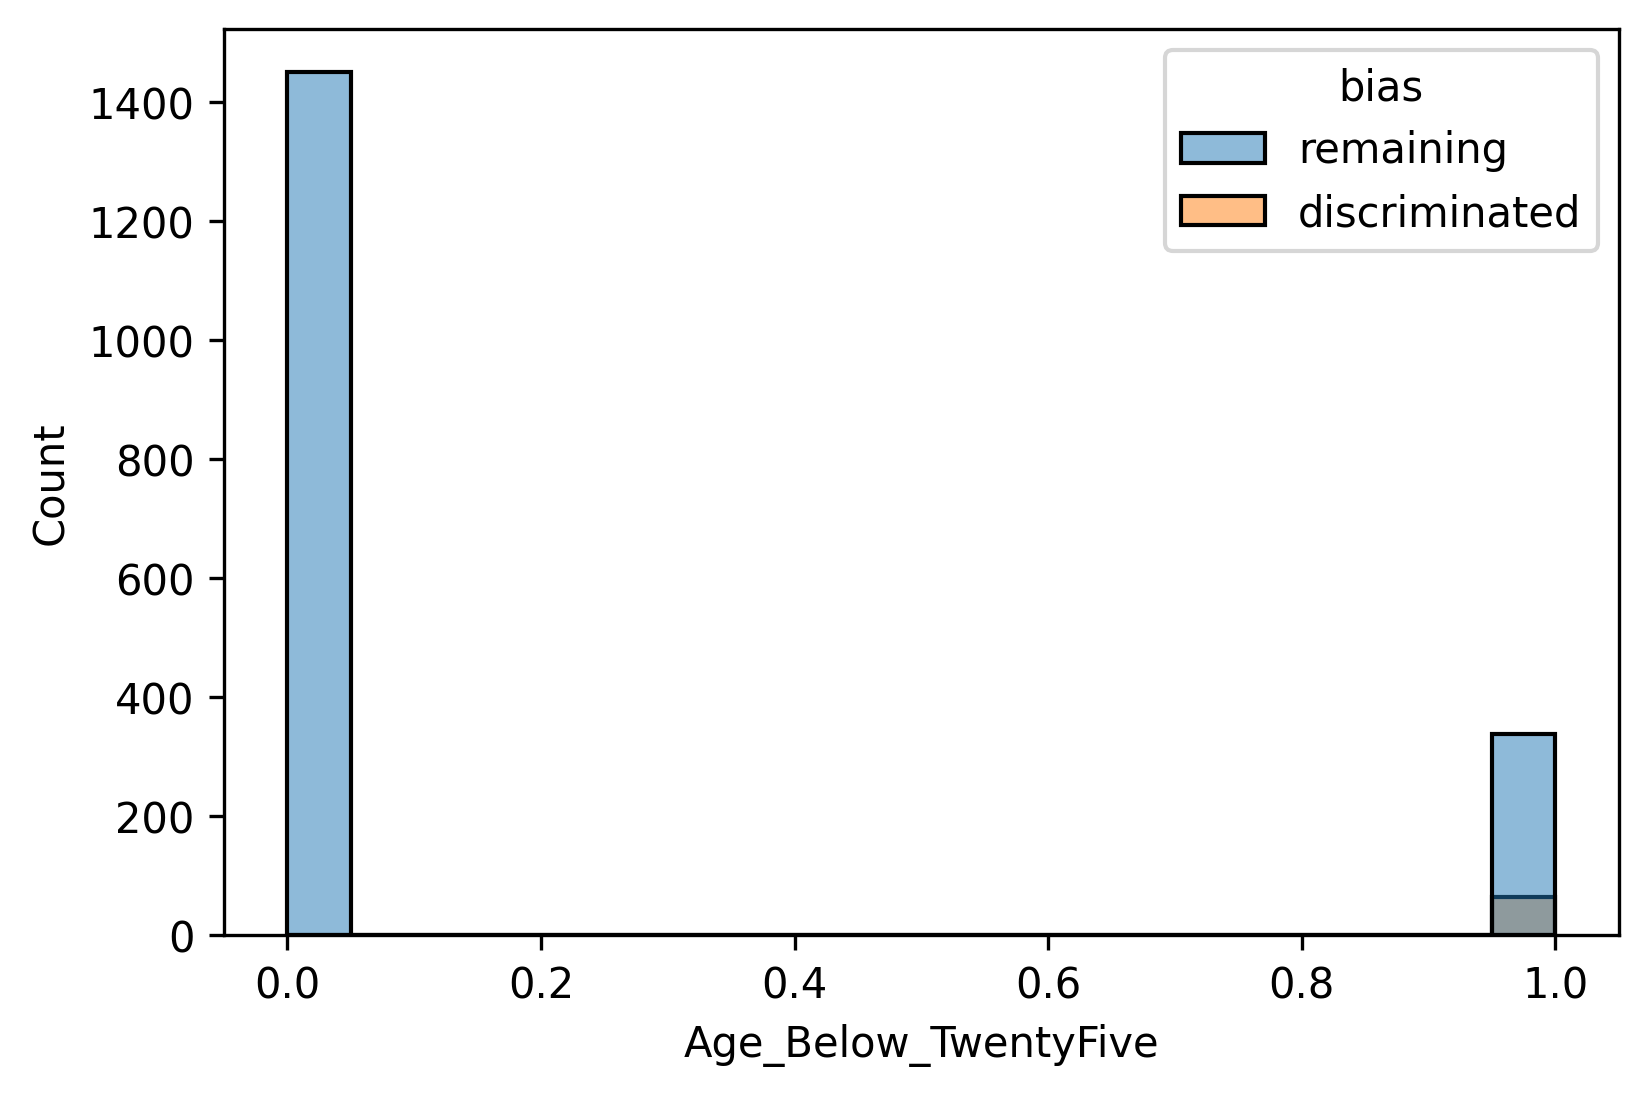

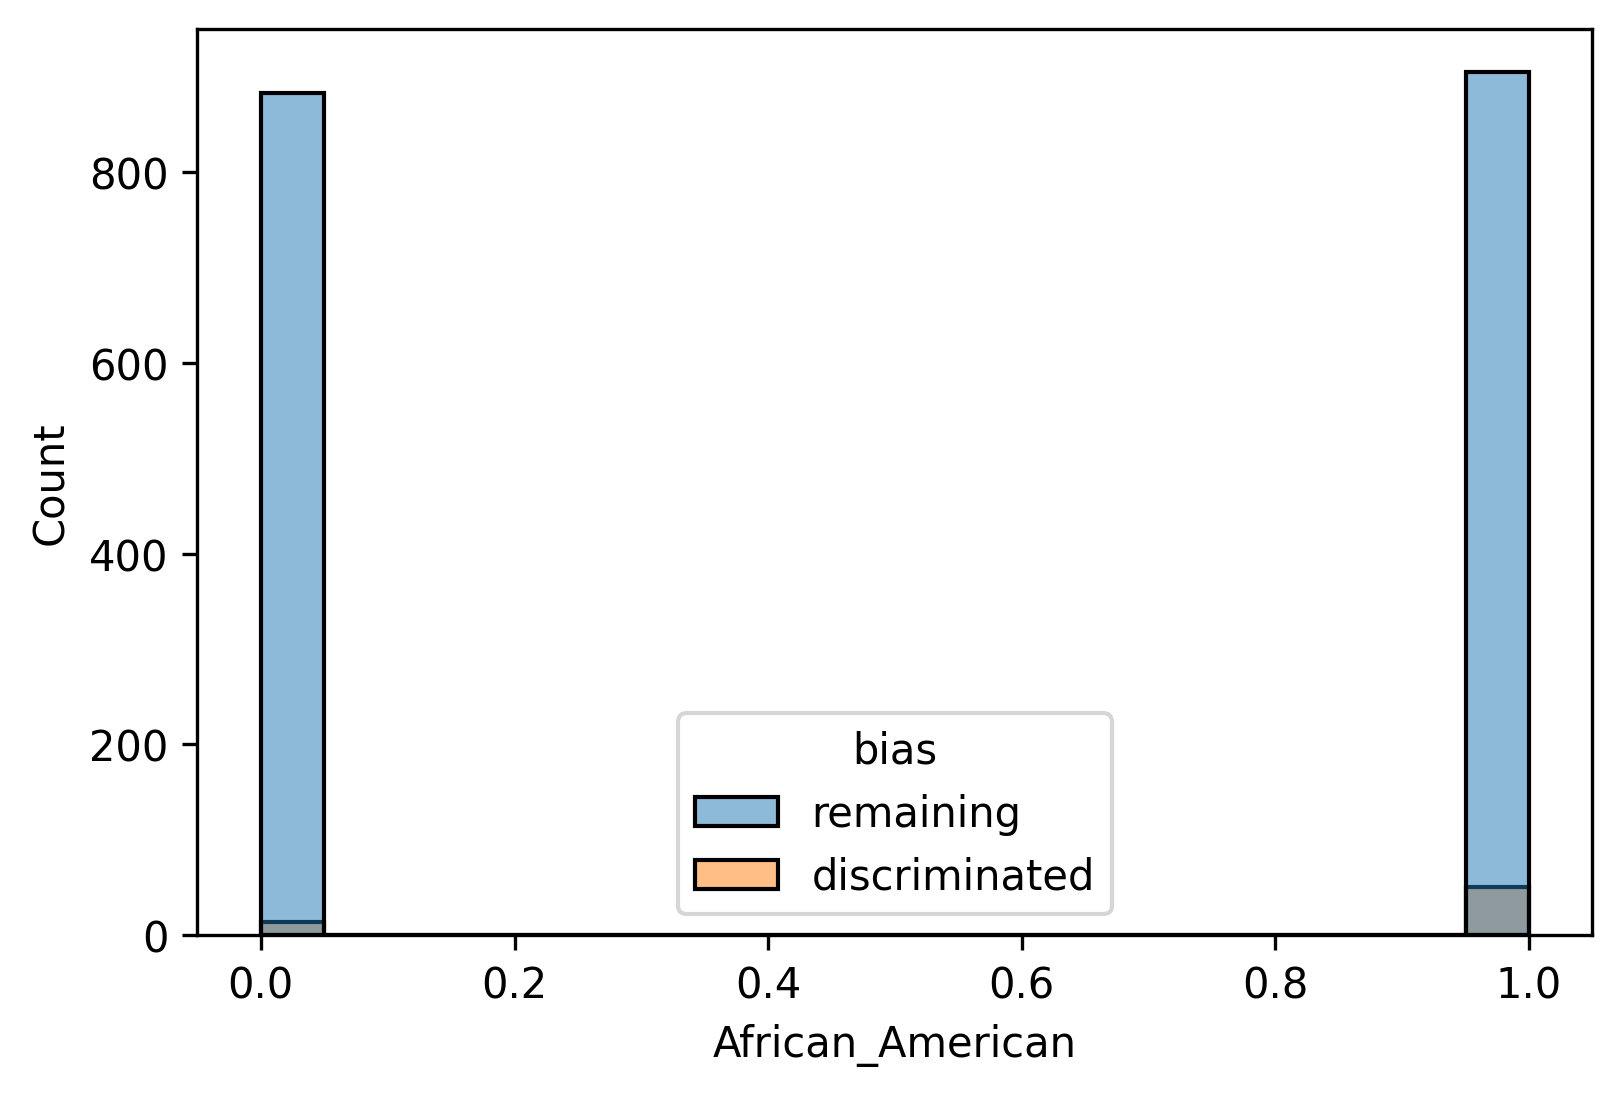

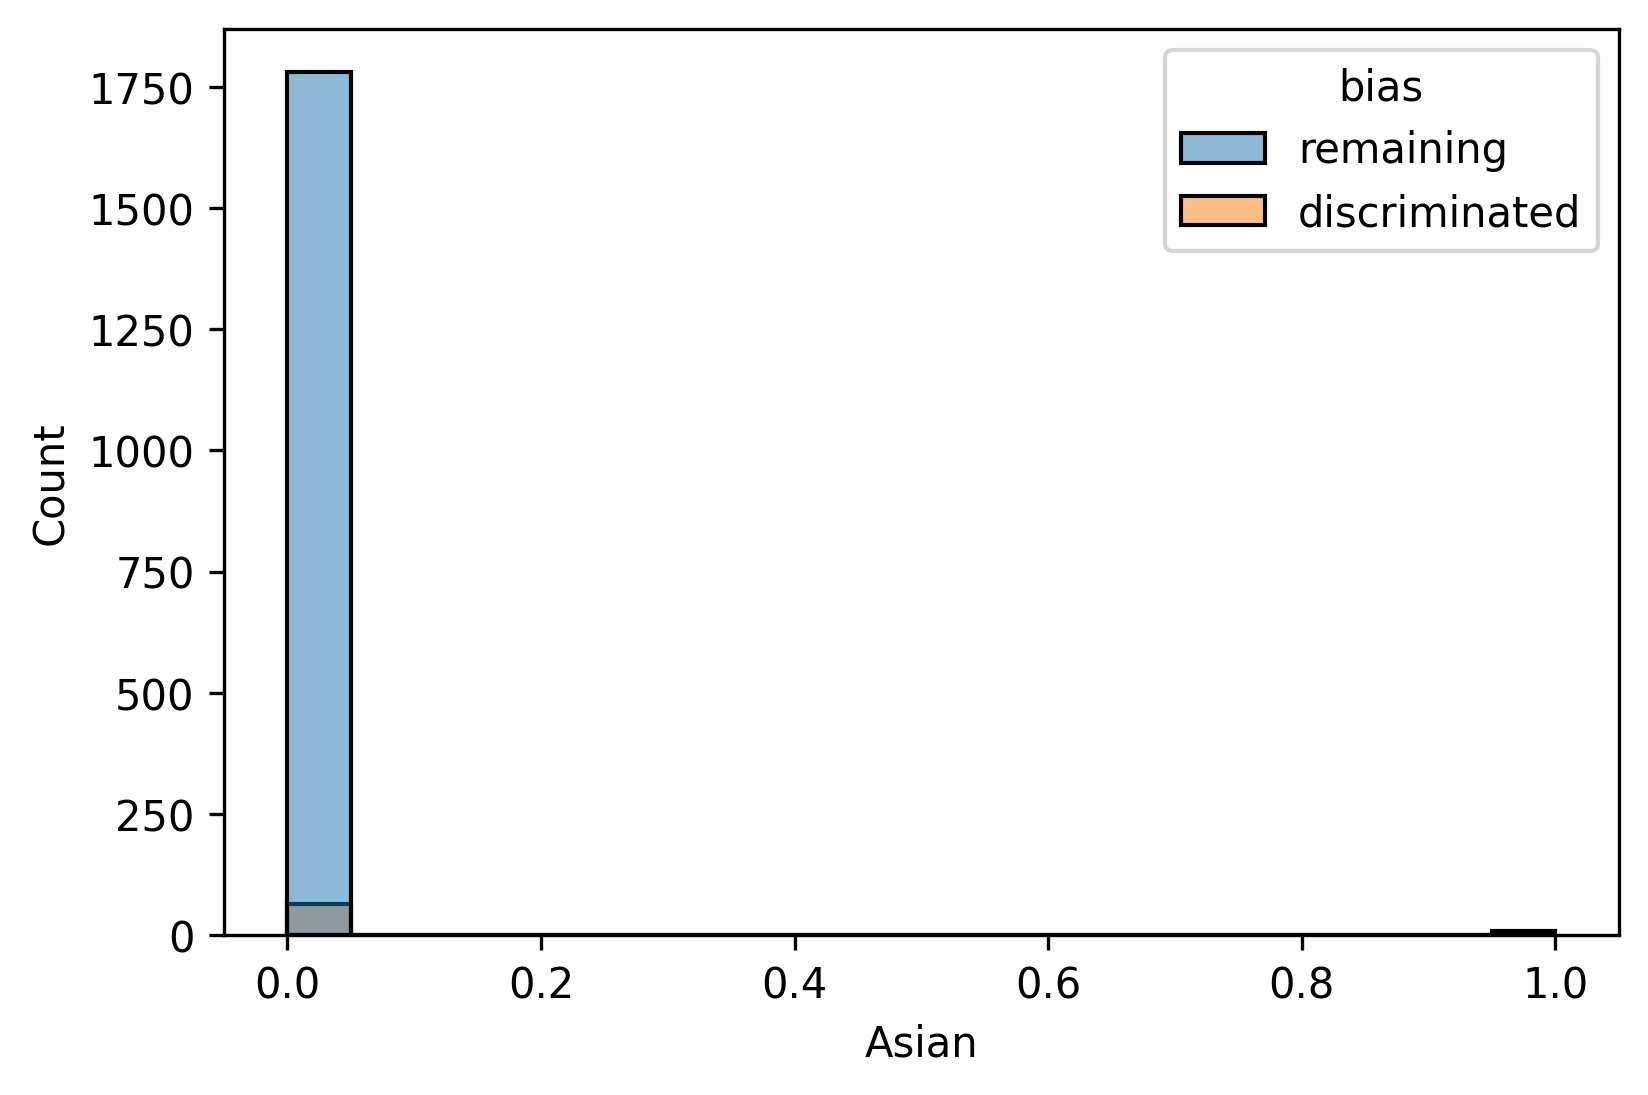

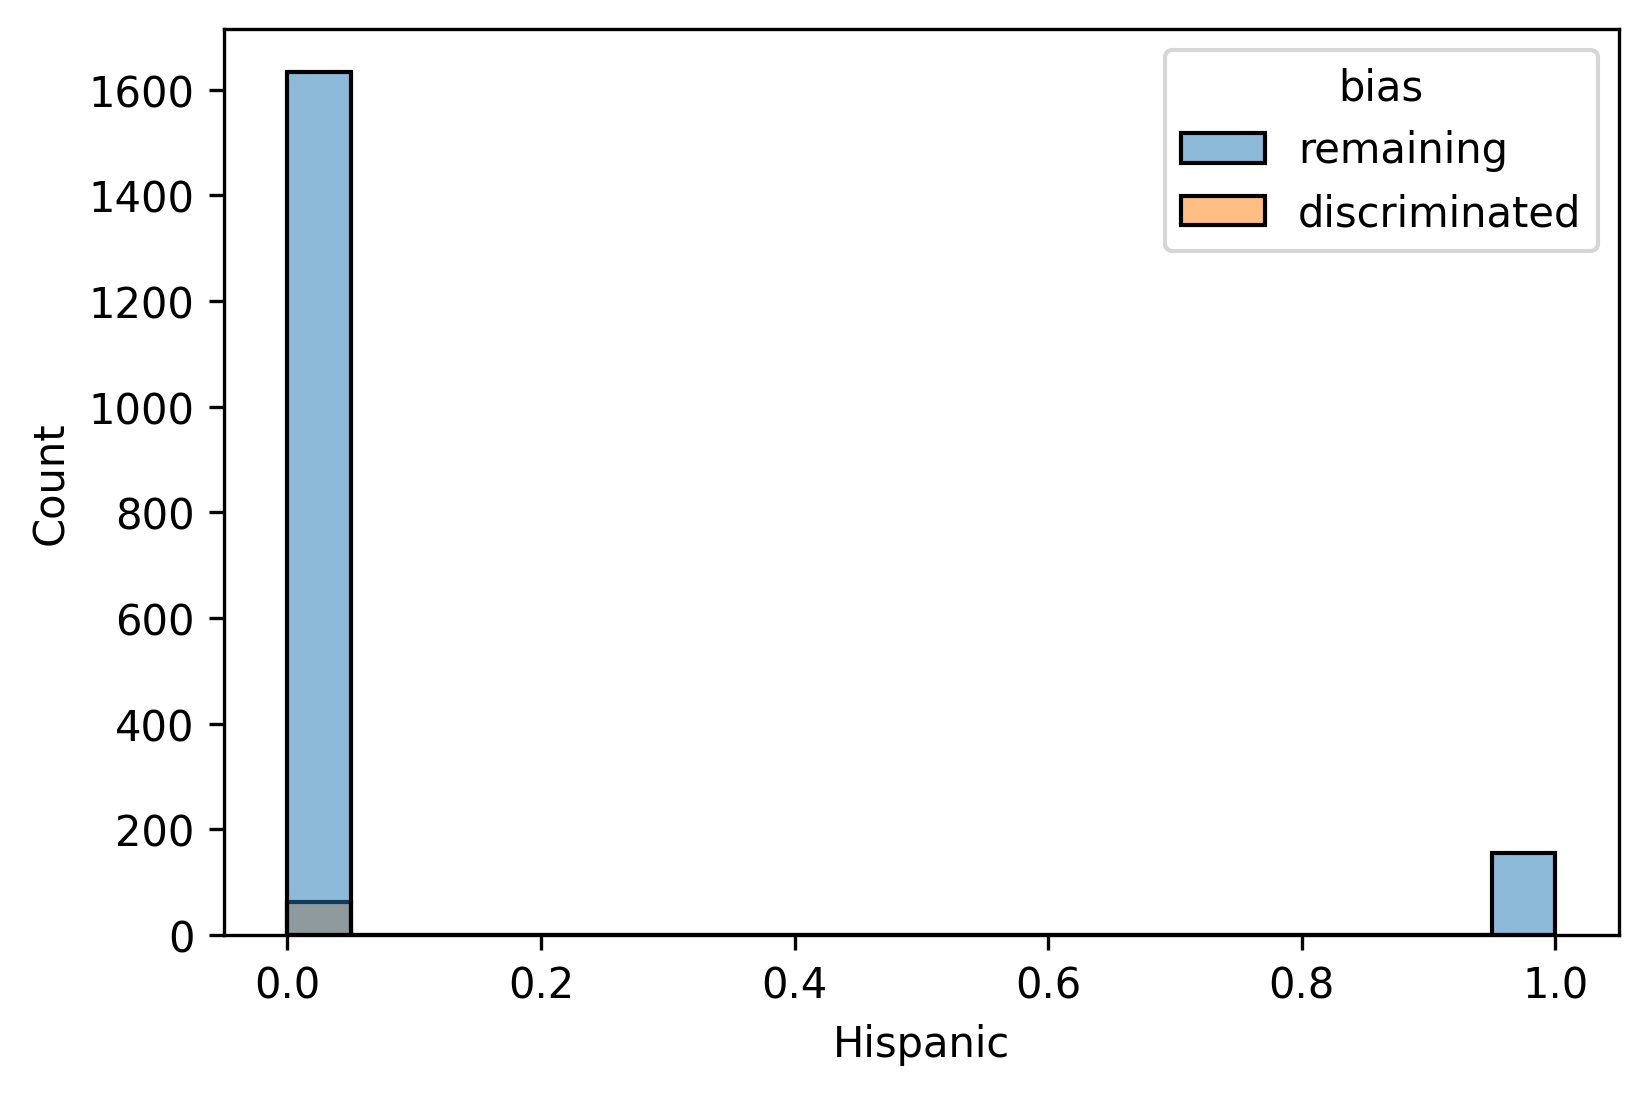

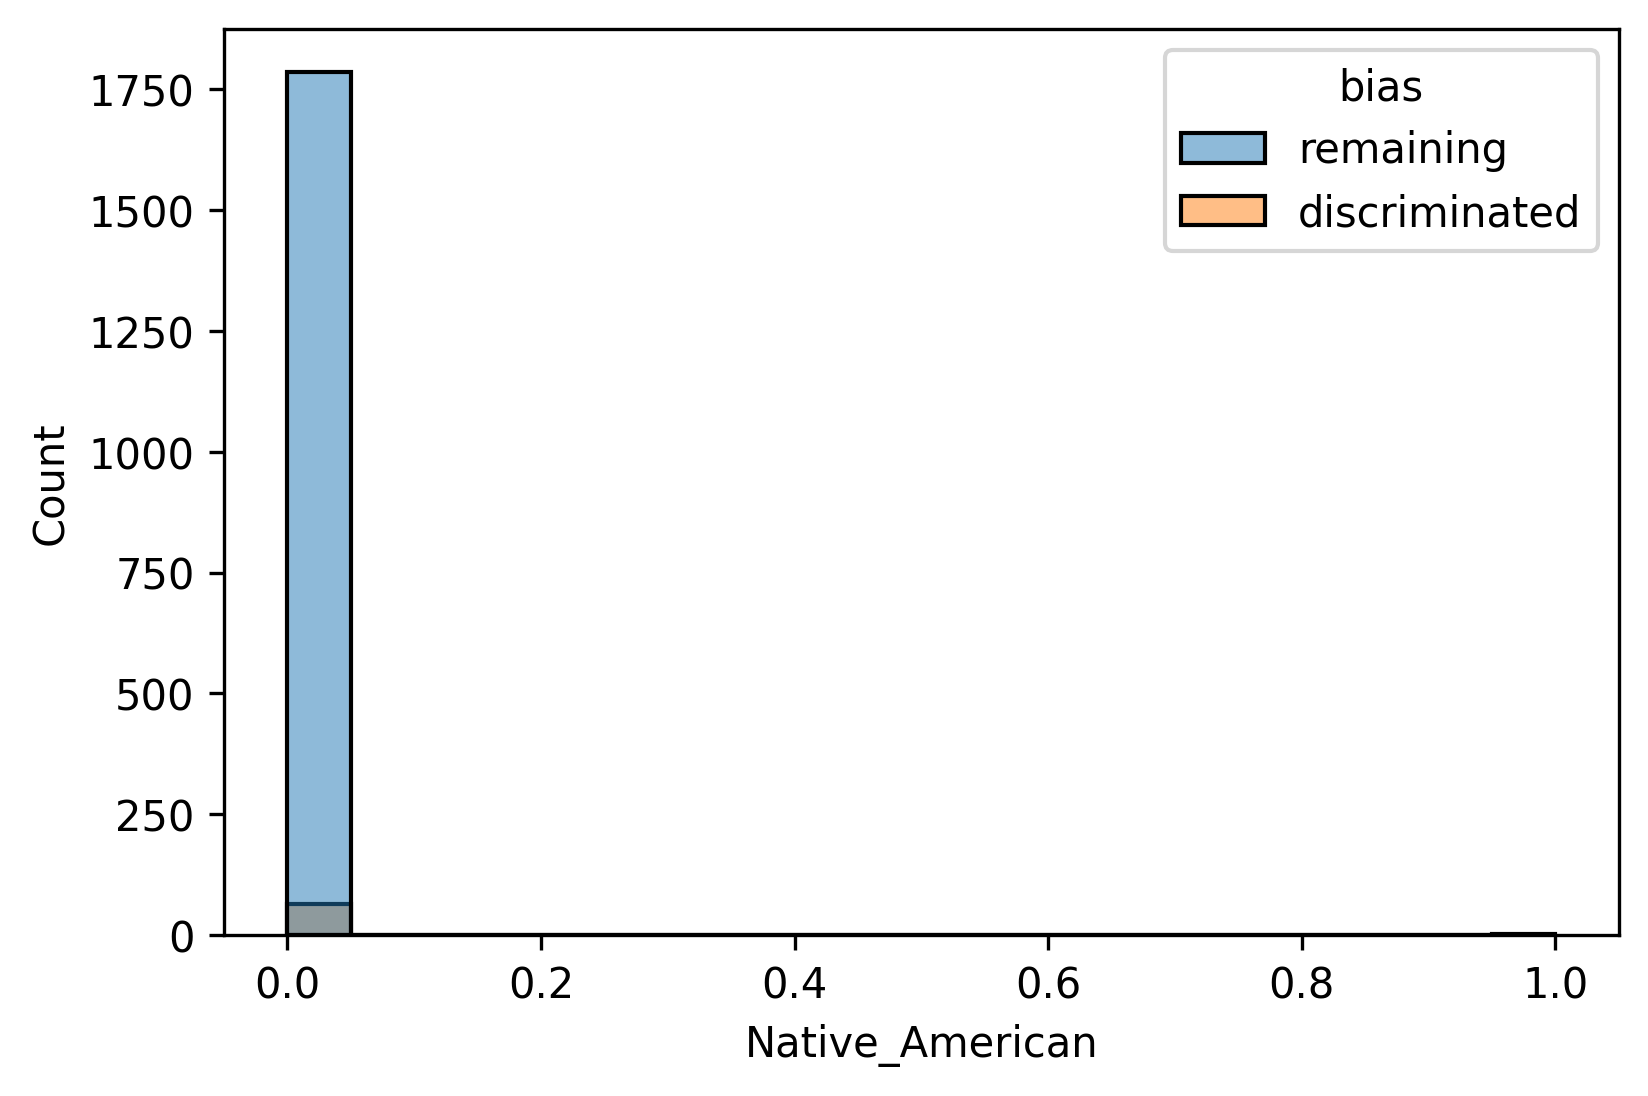

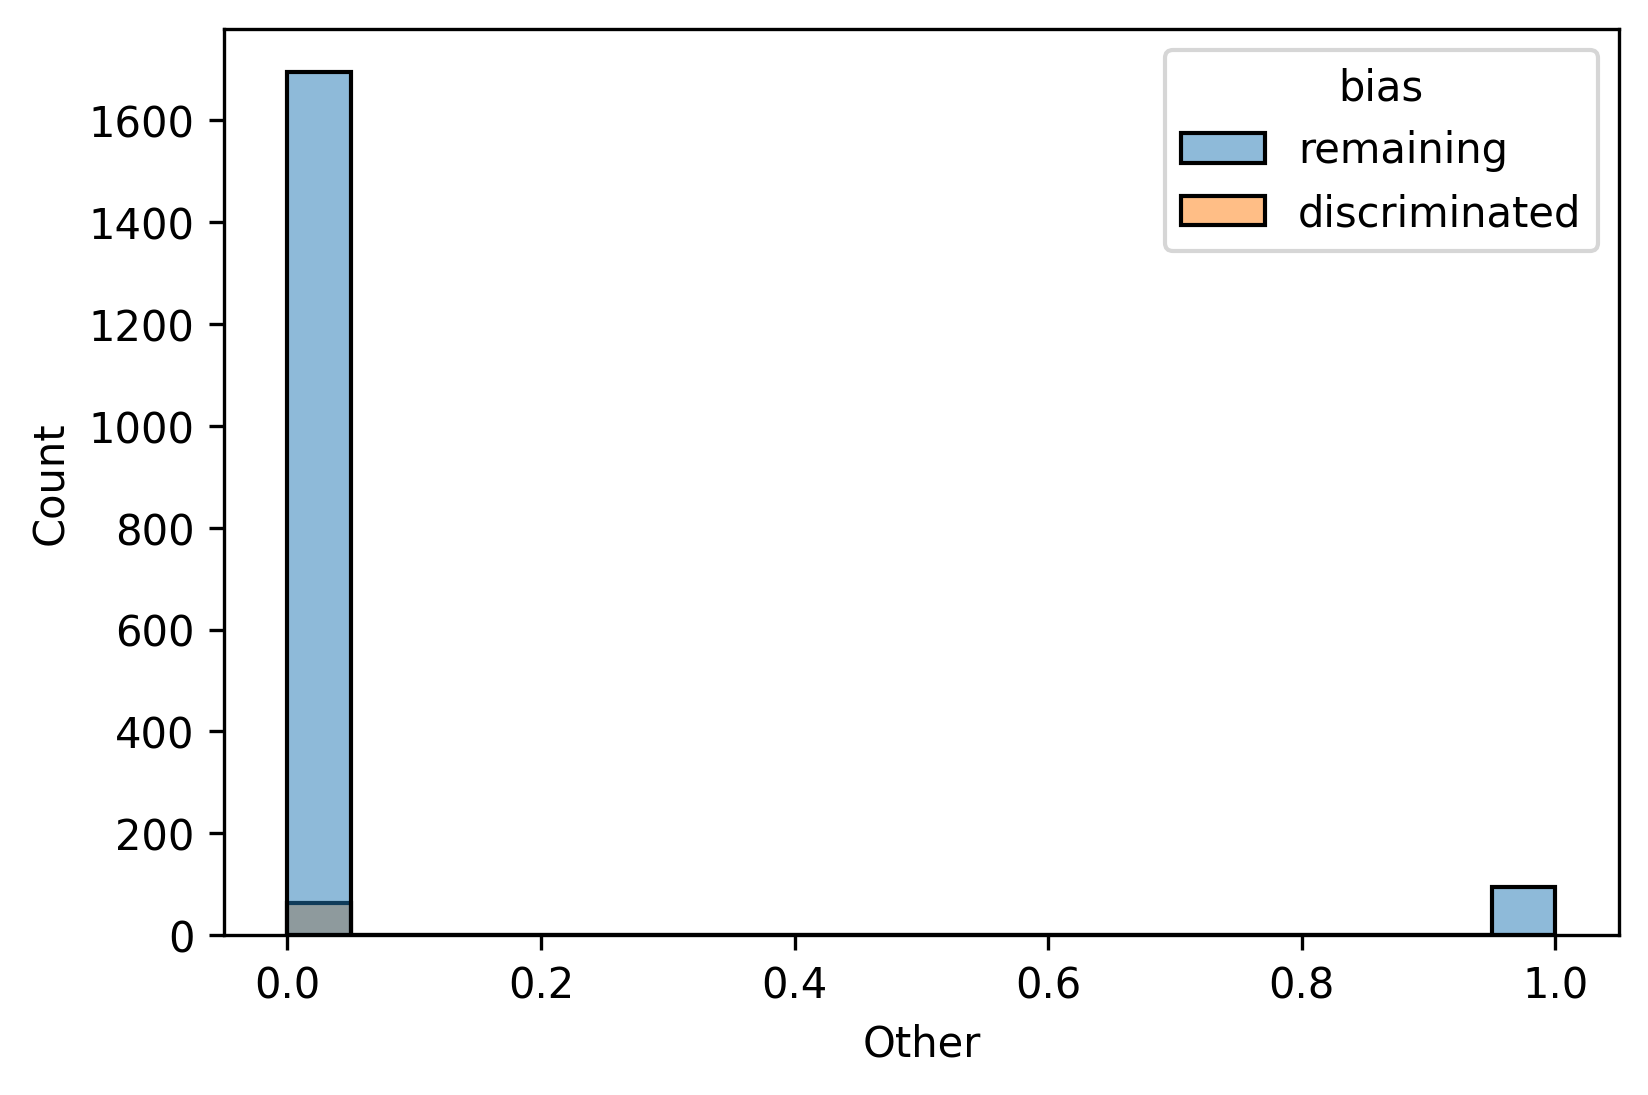

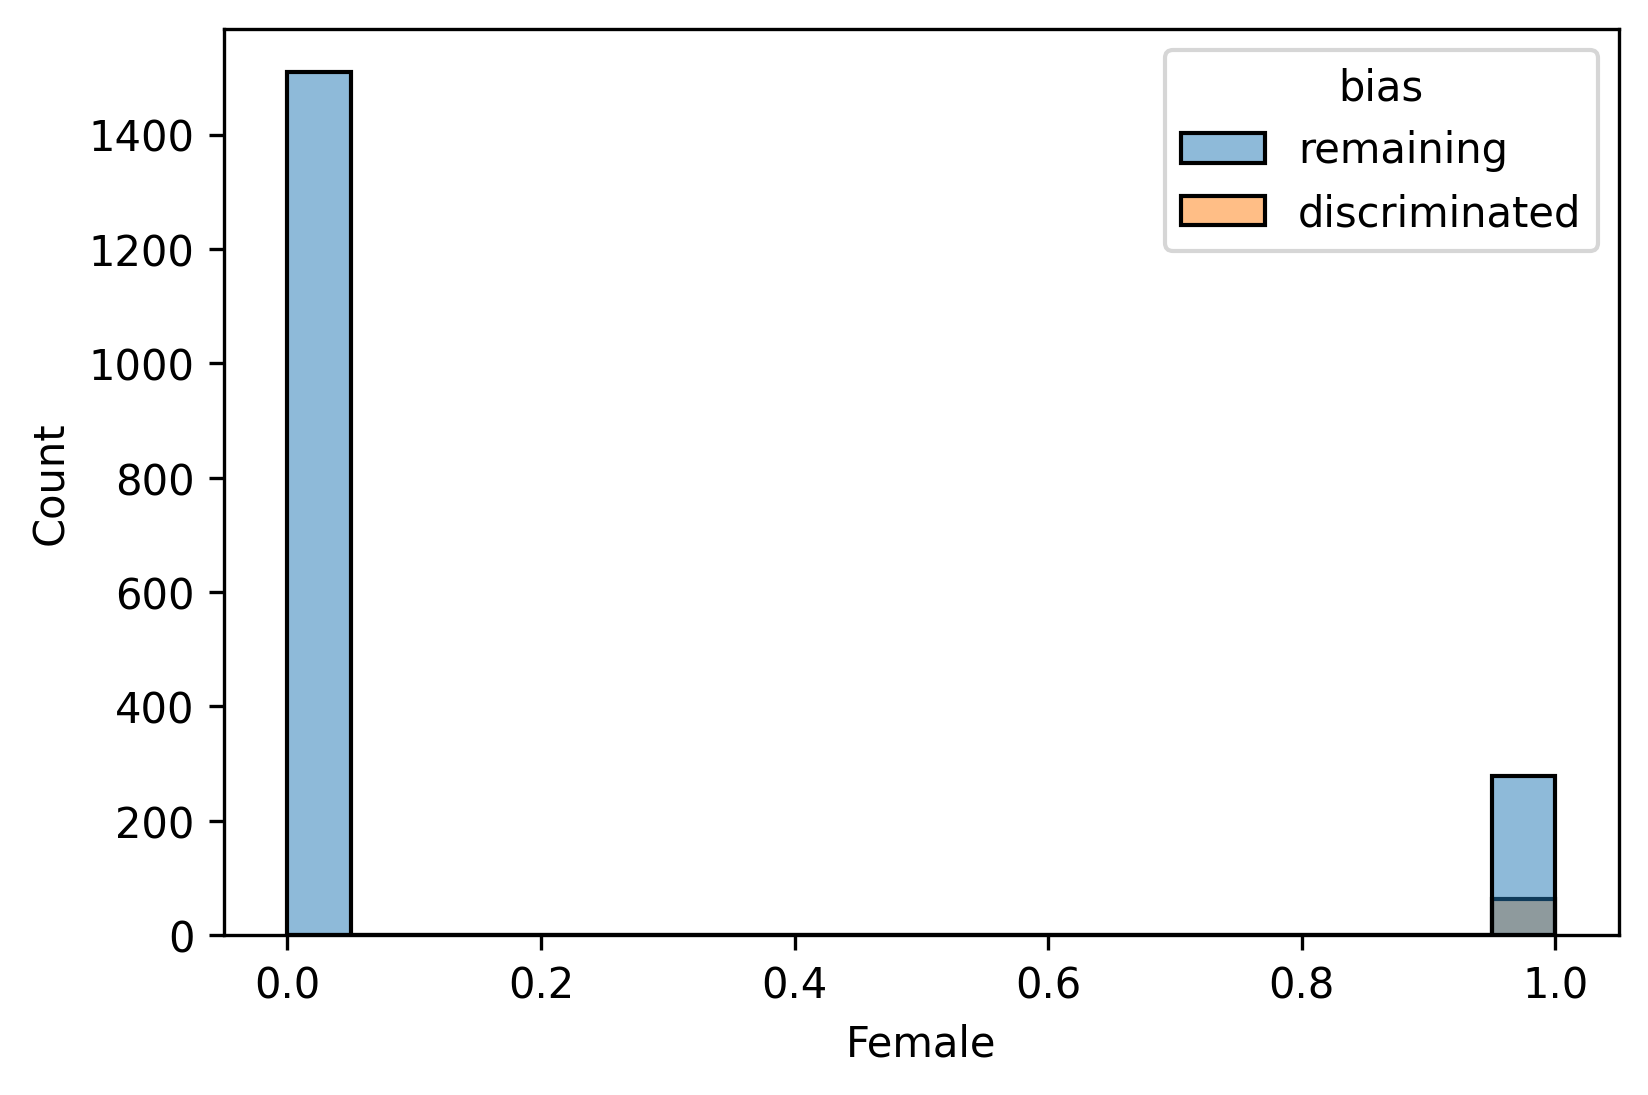

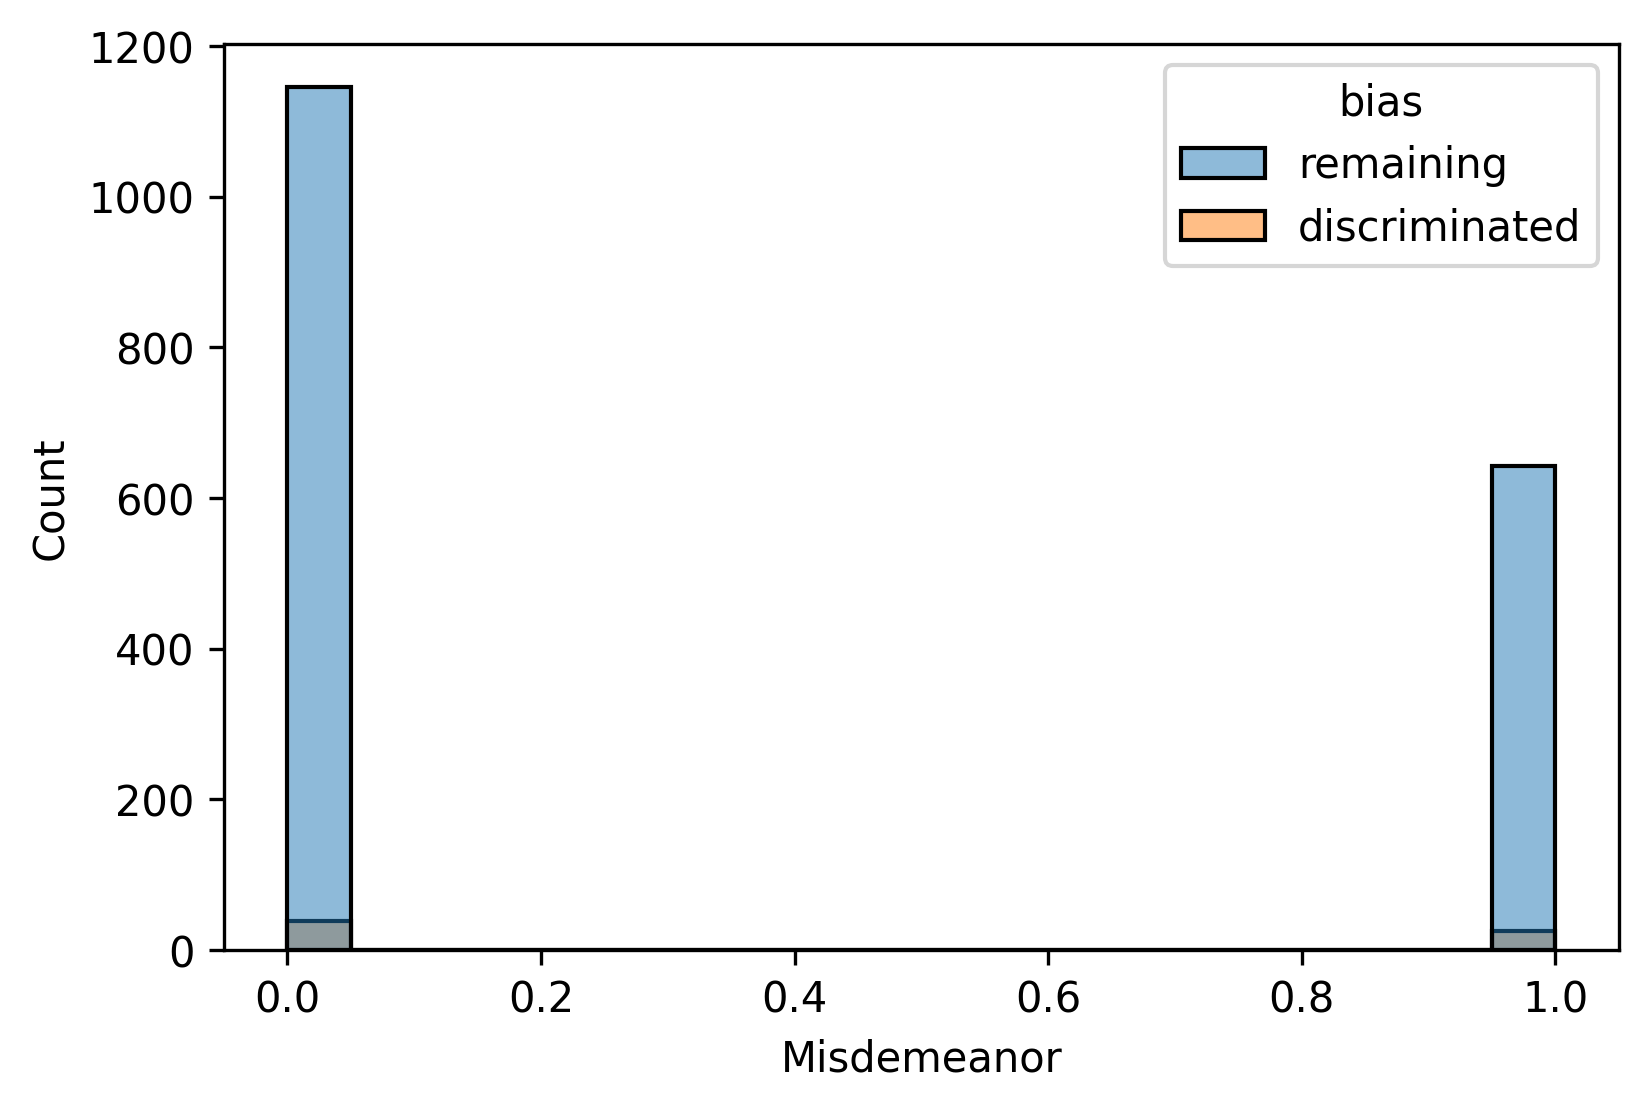

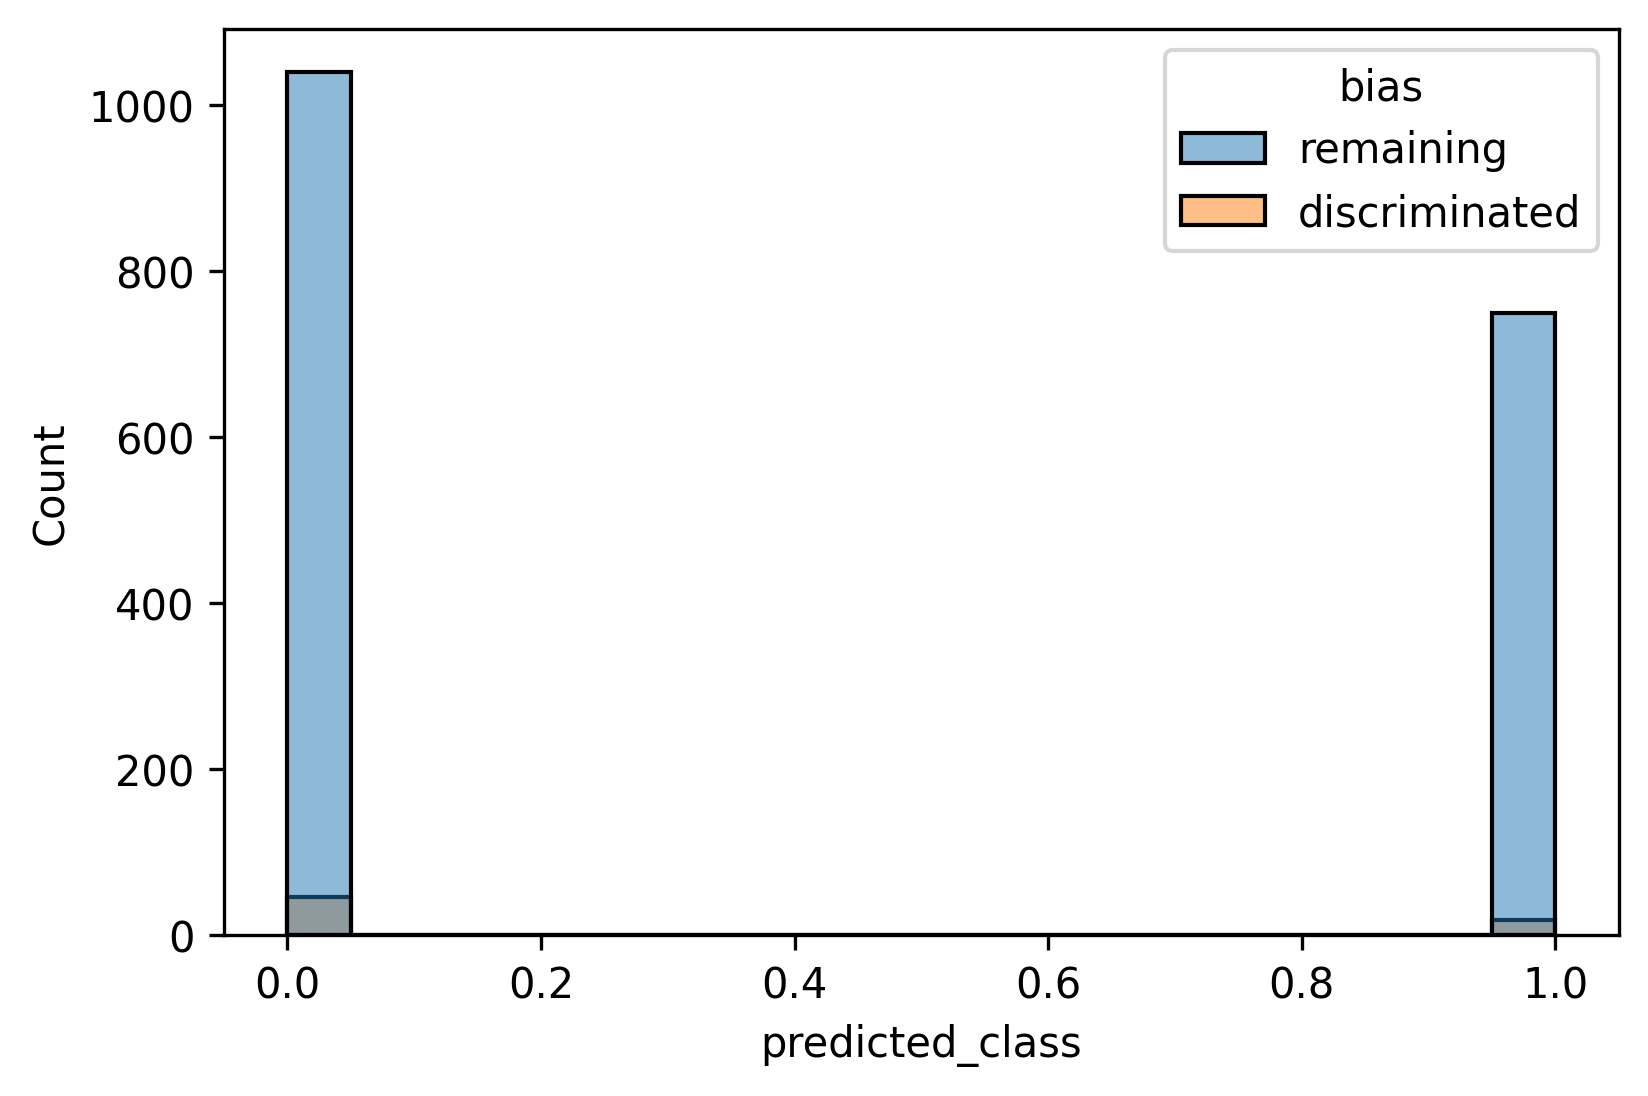

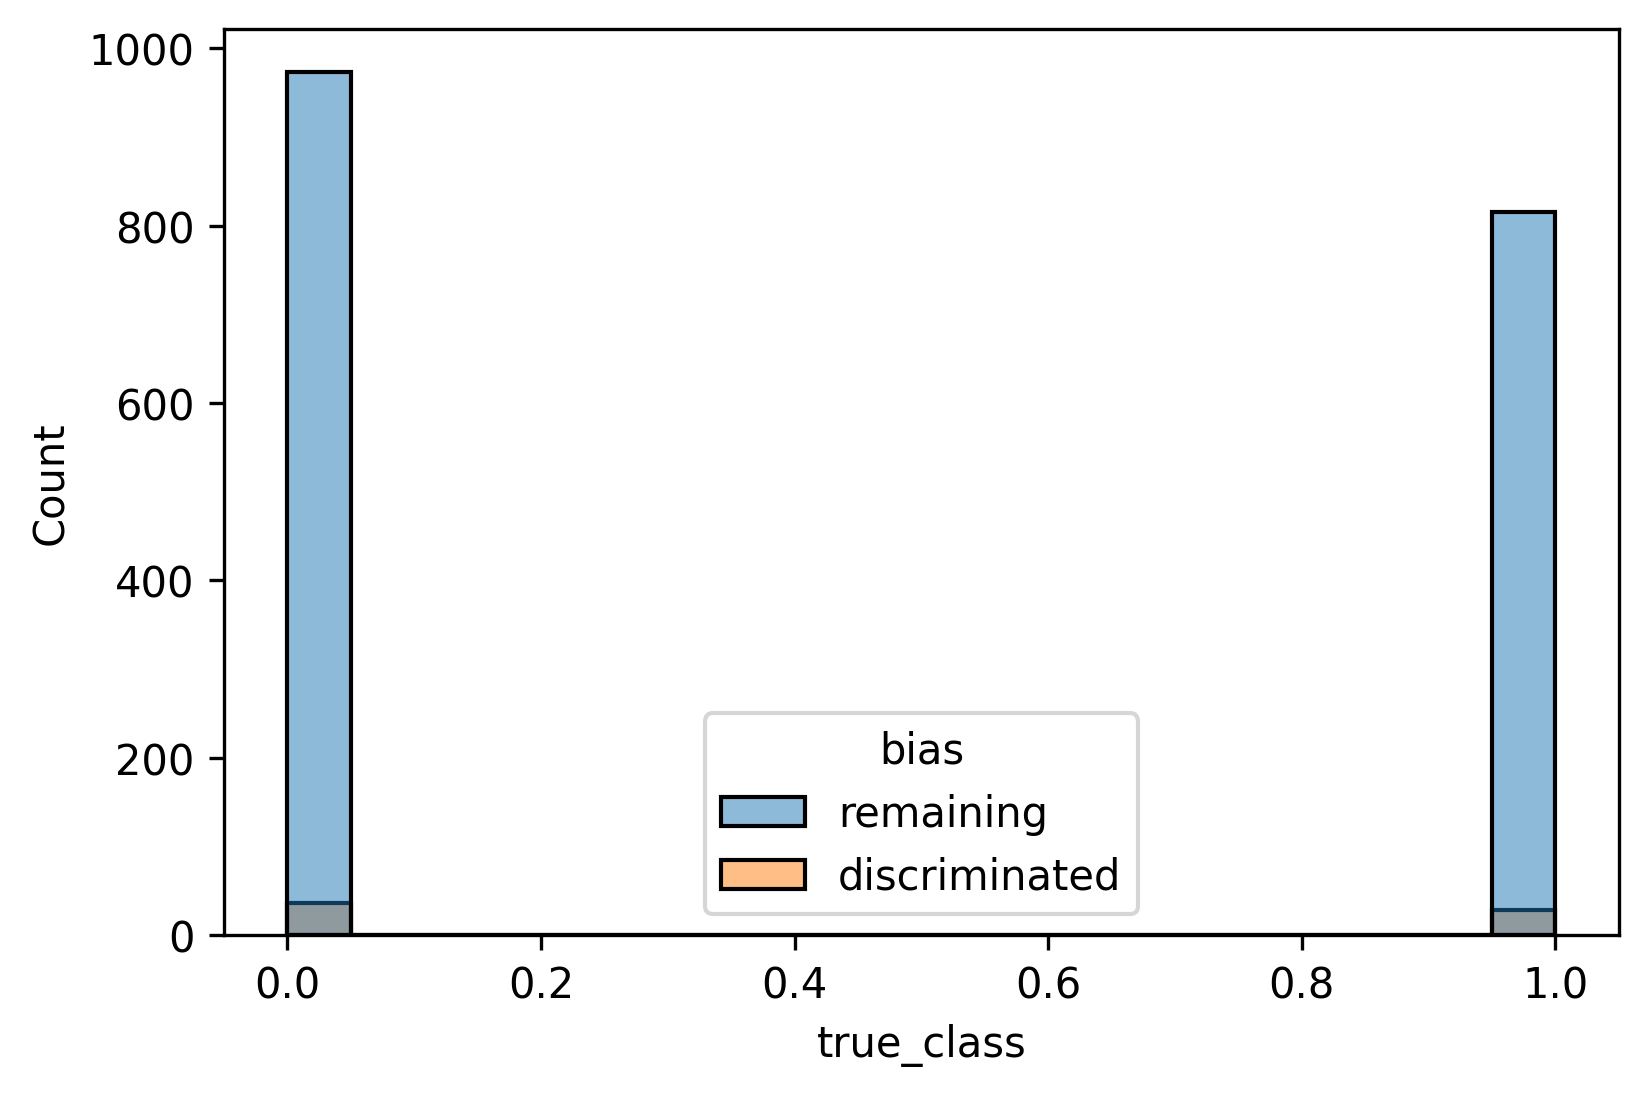

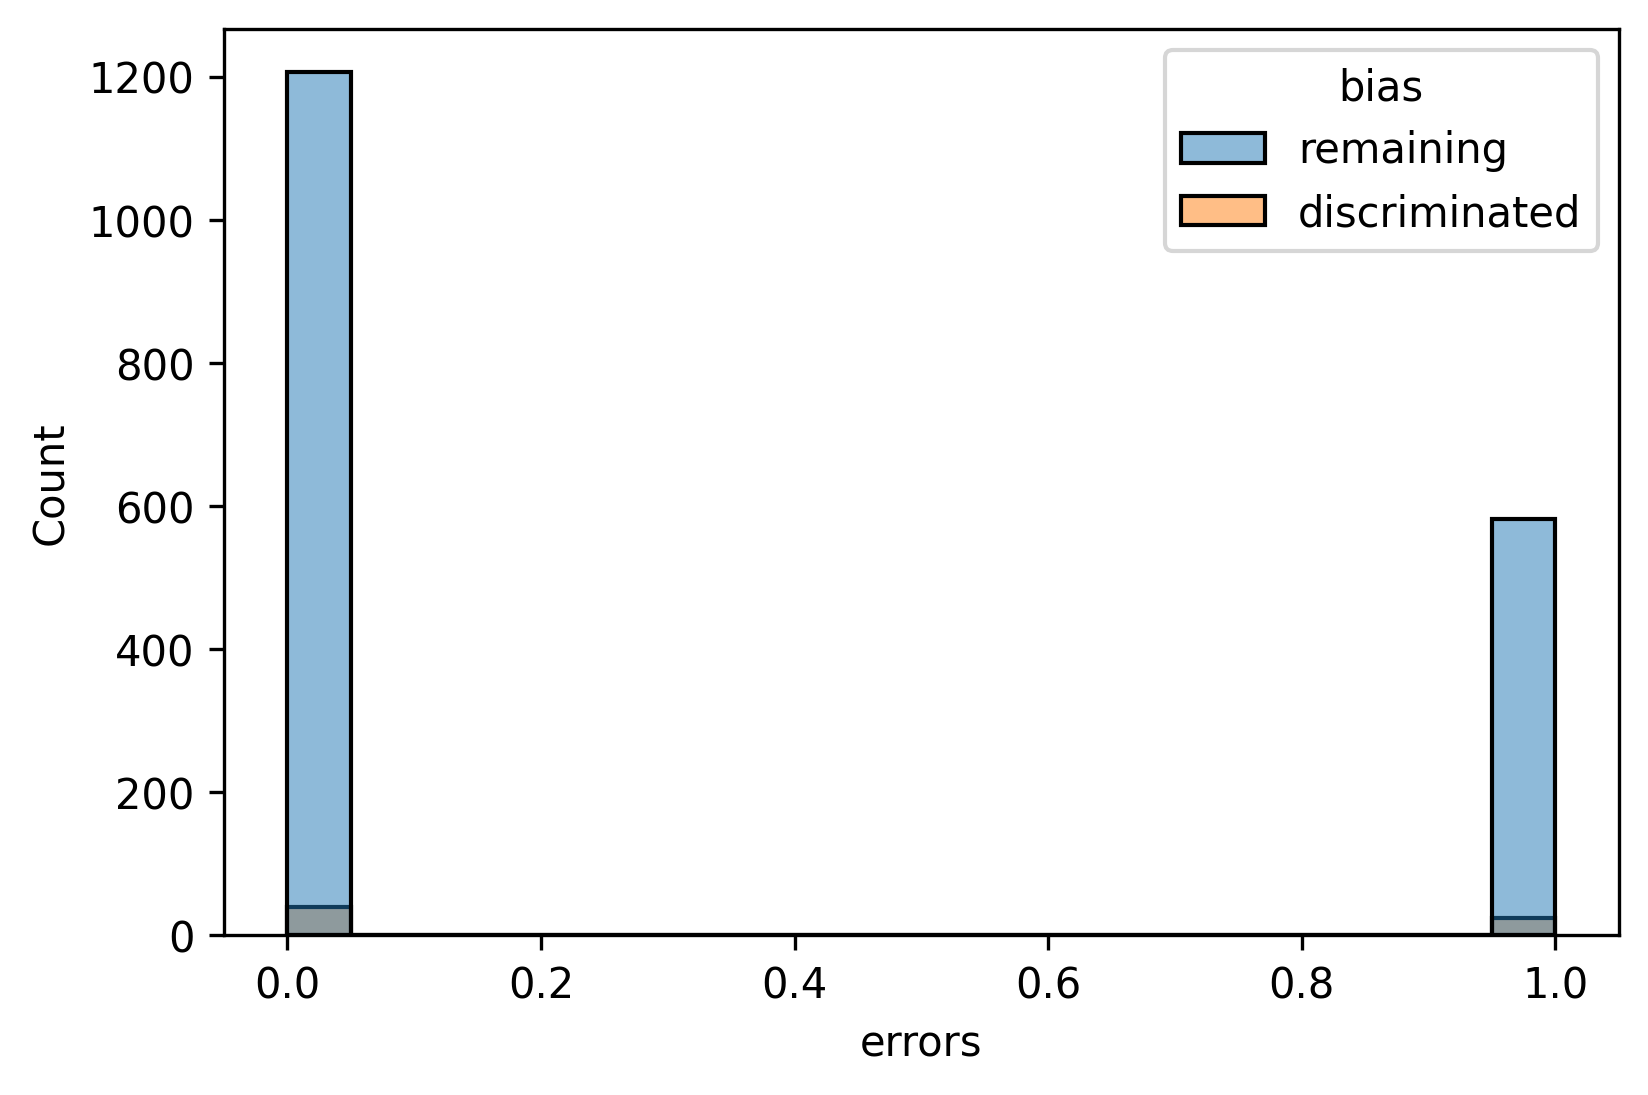

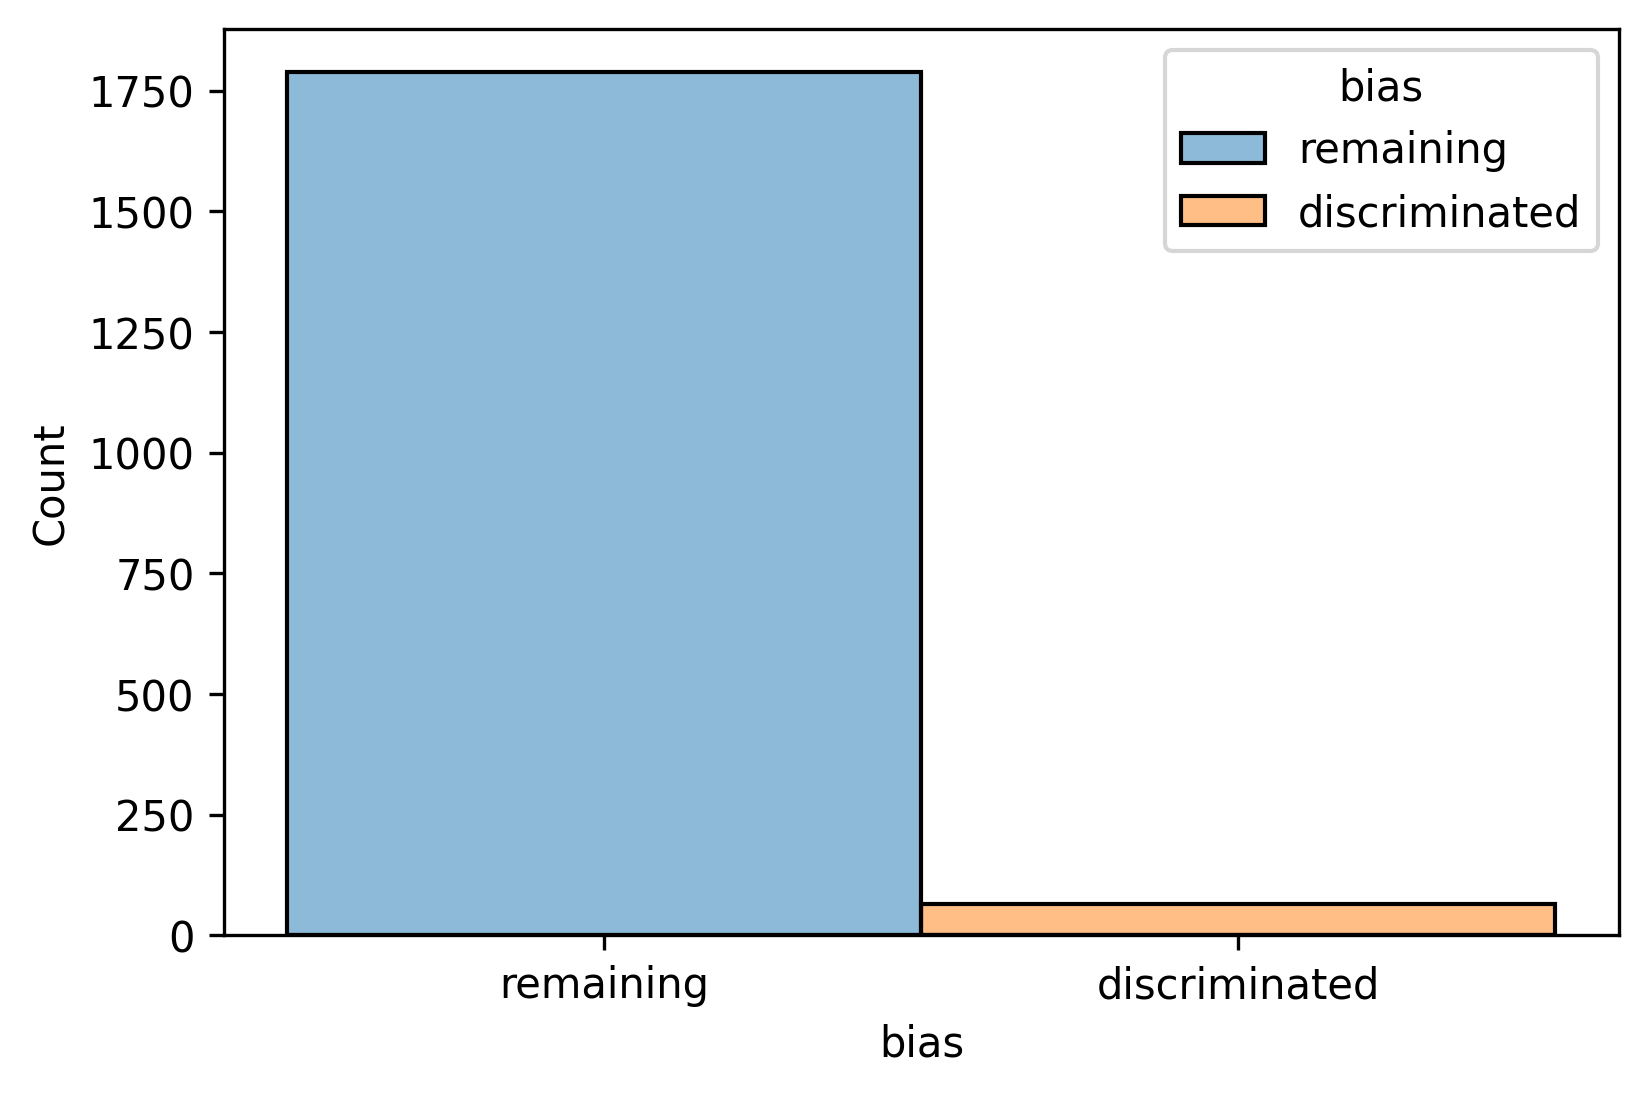

In [29]:
for i in df_all.columns:
    sns.histplot(data=df_all, x=i, hue='bias', bins=20)

    plt.show()

## Seaborn Pairplot / Density plot

In [38]:
sns.pairplot(df_all, hue="bias")

MemoryError: In RendererAgg: Out of memory

MemoryError: In RendererAgg: Out of memory

<Figure size 10933.4x10500 with 210 Axes>